In [1]:
# nb-main.ipynb

## <font color="darkcyan">Разработка рекомендательной системы для электронной коммерции на основе гибридного подхода машинного обучения с учётом пользовательского поведения и контентных характеристик

<font color="darkred">Этот ноутбук нужно запускать первым. Он создаёт pkl-файлы, которые используются в других модулях. Работает с python 3.11 и 3.9

In [4]:
import sys
import os

import numpy as np
import pandas as pd
import calendar
import datetime as dt
import matplotlib.pyplot as plt
import plotly.express as px
import random
import seaborn as sns
import squarify
import time
import warnings

from IPython.display import display,HTML
from collections import defaultdict, Counter
from functools import reduce
from mlxtend.frequent_patterns import apriori,association_rules,fpgrowth
from mlxtend.preprocessing import TransactionEncoder
from pandas.api.types import is_string_dtype
from pathlib import Path
from pyECLAT import ECLAT
from sklearn import metrics,mixture
from sklearn.cluster import KMeans,DBSCAN
from sklearn.decomposition import PCA,TruncatedSVD
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder,normalize
from sklearn.utils import resample
from surprise import SVD,KNNBasic,NMF,Dataset,Reader,accuracy
from surprise.model_selection import train_test_split as sp_train_test_split, cross_validate
from tabulate import tabulate
from tqdm.notebook import tqdm
from xgboost import XGBClassifier,plot_importance
from yellowbrick.cluster import KElbowVisualizer

warnings.simplefilter("ignore")

C:\Anaconda3\Lib\site-packages\yellowbrick\style\colors.py:35: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  mpl_ge_150 = LooseVersion(mpl.__version__) >= "1.5.0"
C:\Anaconda3\Lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Anaconda3\Lib\site-packages\yellowbrick\style\rcmod.py:31: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  mpl_ge_150 = LooseVersion(mpl.__version__) >= "1.5.0"
C:\Anaconda3\Lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


In [5]:
print(f'System version:  {sys.version}')
print(f'Pandas version:  {pd.__version__}')

System version:  3.11.9 | packaged by Anaconda, Inc. | (main, Apr 19 2024, 16:40:41) [MSC v.1916 64 bit (AMD64)]
Pandas version:  2.2.1


In [6]:
from settings import *
from user_func import prdf
DEBUG = True
os.environ['OMP_NUM_THREADS'] = '8'

In [7]:
start_time = time.time()

In [8]:
pd.options.display.float_format = "{:,.2f}".format
warnings.simplefilter("ignore")
%matplotlib inline

In [9]:
def filter_users_by_purchase(dataframe, threshold, by='sum', ascending=False):
    if by == 'sum':
        # Группировка по пользователям и суммирование цен покупок
        grouped_data = dataframe.groupby('user_id')['price'].sum()
    elif by == 'count':
        # Группировка по пользователям и подсчет количества покупок
        grouped_data = dataframe.groupby('user_id')['price'].count()
    else:
        raise ValueError("Argument 'by' should be either 'sum' or 'count'.")
    
    # Фильтрация пользователей с суммой/количеством покупок выше заданного порога
    filtered_users = grouped_data[grouped_data <= threshold]
    # Сортировка значений
    sorted_users = filtered_users.sort_values(ascending=ascending)
    return sorted_users

def columnValues(df):
    row = [df.nunique(), (df == 0).sum(axis=0), df.isna().sum(), (df=='').sum(), round(df.isna().sum() / len(df) * 100, 1), df.dtypes]
    return row

def dataset_stats(dataset):
    # Для каждого столбца выведем: количество уникальных значений, нулевых, NaNs и их долю, а также тип данных в столбцах.
    data = []
    for column in dataset:
        data.append([column] + columnValues(dataset[column]))
    display(HTML(tabulate(data, headers=['Column', 'Count Unique', 'Count Zeros', 'Count NaNs', 'Count Empty', '% of NaNs', 'data type'], tablefmt='html', floatfmt=(".0f"))))

def filter_dataset(use_cache = False):
    '''
    Удаление данных, непригодных для анализа
    '''
    # Из-за большого объёма данных переменная объявлена глобальной,
    # чтобы не выделять память под временную
    global dataset
    steps = 10
    if not use_cache or not ds_flt_file.is_file():
        # Исключаем из рассмотрения данные после 13.11.2019
        #dataset['event_time'] = pd.to_datetime(dataset['event_time']).dt.date
        #limit = dt.datetime.strptime('2019-11-13 00:00:00 +0000 (UTC)','%Y-%m-%d %H:%M:%S %z (%Z)')#.date()
        # 01.10.2019 (Tue)-11.11.2019 (Mon)
        # Можно было бы удалить чёрную пятницу и сдвинуть даты, чтобы они шли подряд, но
        # после чёрной пятницы будет спад активности и нехарактерное поведение, поэтому
        # был выбран именно такой способ.
        
        # Каждый день недели присутствует с одинаковой частотой, 
        # т.к. мы начинаем датасет во вторник, а заканчиваем - в понедельник.
        limit = '2019-11-12 00:00:00 +0000 (UTC)'

        if DEBUG:
            print(f'Initial size: {dataset.shape}')
            print(f'Deleting data after {limit} #1/{steps}') 
            
        # Удаляем "чёрную пятницу" и дни после неё, т.к. разрыв в датах недопустим,
        # а заполнять пропуски фальшивыми данными не хочется.
        dataset.drop(dataset[dataset['event_time'] >= limit].index, inplace=True)
        if DEBUG:
            print(dataset.shape)

        # Удаляем строчки с NaN
        if DEBUG:
            print(f'Delete incomplete records (NaN) #2/{steps}')
        dataset = dataset.dropna(axis='rows')
        if DEBUG:
            print(dataset.shape)
            
        # Удаляем из датасета смартфоны
        # electronics.smartphone -> smartphone 
        if DEBUG:
            print(f'Delete smartphones data #3/{steps}')  
        dataset.drop(dataset[dataset['category_code'] == 'electronics.smartphone'].index, inplace=True)
        if DEBUG:
            print(dataset.shape)

        # Удаляем из датасета строки с неполными данными (пустая строка в любом поле)
        if DEBUG:
            print(f'Delete incomplete data (blank) #4/{steps}')
        for column in tqdm(dataset.columns):
            blank_field = dataset[dataset[column]==''].shape[0]
            if blank_field > 0:
                dataset.drop(dataset[dataset[column] == ''].index, inplace=True)    
        if DEBUG:
            print(dataset.shape)

        if DEBUG:
            print(f'Delete clients shopped over {MAX_TOTAL} #5/{steps}')
        # Выделим клиентов, совершивших покупки на сумму больше 125000
        user_id_list = filter_users_by_purchase(dataset, MAX_TOTAL, by='sum').index.to_list()
        #len(user_id_list)
        # исключим их из датасета
        dataset = dataset[dataset.user_id.isin(user_id_list)]
        if DEBUG:
            print(dataset.shape)

        if DEBUG:
            print(f'Delete clients bought over {MAX_ITEMS} items #6/{steps}')
        # Выделим клиентов, купивших более 150 товаров
        user_id_list = filter_users_by_purchase(dataset, MAX_ITEMS, by='count').index.to_list()
        # исключим их из датасета
        dataset = dataset[dataset.user_id.isin(user_id_list)]
        if DEBUG:
            print(dataset.shape)
        
        # На основе анализа корреляции исключаем код категории товара, т.к. остаётся текстовое описание
        if 'category_id' in dataset.columns:
            dataset.drop(['category_id'], axis=1, inplace=True)
        if DEBUG:
            print(f'Split category_code to 2 columns #7/{steps}')
        if 'category_code_level1' not in dataset.columns:
            dataset['category_code_level1'] = dataset['category_code'].str.rsplit(".",n=1,expand=True)[0].astype('category')
            dataset['category_code_level2'] = dataset['category_code'].str.rsplit(".",n=1,expand=True)[1].astype('category')
            #dataset.drop(['category_code'], axis=1, inplace=True)
        if DEBUG:
            print(dataset.shape)

        if DEBUG:
            print(f'Leave only buyers #8/{steps}')
        # Выделим клиентов, совершивших покупки и сохраним все записи, в т.ч. view и cart
        purchase = dataset.loc[dataset['event_type'] == 'purchase']
        user_id_list = list(set(purchase.user_id))
        # Удаляем всех остальных.
        dataset = dataset[dataset.user_id.isin(user_id_list)]
        if DEBUG:
            print(dataset.shape)
            
        if DEBUG:
            print(f'Add week day column #9/{steps}')
        # Добавляем день недели Monday is 0 and Sunday is 6.
        dataset['dow'] = pd.to_datetime(dataset['event_time']).dt.day_name()
        if DEBUG:
            print(dataset.shape)

            
        # Сохраняем кэш файл
        #if not ds_flt_file.is_file():
        if DEBUG:
            print(f'Save filtered data to {ds_flt_file} #10/{steps}')


        dataset.to_pickle(ds_flt_file)

    # Если собрана модель RFM - применяем дополнительную фильтрацию
    if DEBUG:
        print('Дополнительная фильтрация данных на основании модели RFM')
    if 'rfm_df' in locals():
        dataset = dataset[dataset['user_id'].isin(rfm_df['user_id'])]   
    if DEBUG:
        print(dataset.shape)

# Функция для оптимизации типов данных - не используется
def reduce_memory_usage(df):
    float_cols = df.select_dtypes(include=['float'])
    int_cols = df.select_dtypes(include=['int'])
    object_cols = df.select_dtypes(include=['object'])

    for col in float_cols.columns:
        df[col] = pd.to_numeric(df[col], downcast='float')

    for col in int_cols.columns:
        df[col] = pd.to_numeric(df[col], downcast='integer')
    """
    for col in object_cols.columns:
        num_unique_values = len(df[col].unique())
        num_total_values = len(df[col])
        if float(num_unique_values) / float(num_total_values) < 0.5:
            df[col] = df[col].astype('category')
    """
    return df

# Чтение данных из оригинальных файлов, либо из кэшированной копии
def read_data(use_cache=True):
    if use_cache and ds_flt_file.is_file():
        print('Reading data from cache file')
        dataset = pd.read_pickle(ds_flt_file)
    else:
        # Чтение данных
        dataset = pd.DataFrame()
        for file_read in [file_oct, file_nov]:
            print(f'Reading file: {file_read}')
            tmp = pd.read_csv(file_read, engine = 'pyarrow')
            dataset = pd.concat([dataset, tmp], ignore_index = True)
        print(f'Dataframe length:{len(dataset)}')
    return dataset

In [10]:
%%time
# 5min 13s
dataset = read_data(True)

Reading file: .\cache\2019-Oct.csv
Reading file: .\cache\2019-Nov.csv
Dataframe length:109950743
CPU times: total: 5min 4s
Wall time: 3min 25s


In [11]:
%%time
# 2min 52s
dataset_stats(dataset)
print(f'Количество строк в датафрейме: {dataset.shape[0]}')

Количество строк в датафрейме: 109950743
CPU times: total: 2min 50s
Wall time: 2min 48s


In [12]:
%%time
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109950743 entries, 0 to 109950742
Data columns (total 9 columns):
 #   Column         Dtype  
---  ------         -----  
 0   event_time     object 
 1   event_type     object 
 2   product_id     int64  
 3   category_id    int64  
 4   category_code  object 
 5   brand          object 
 6   price          float64
 7   user_id        int64  
 8   user_session   object 
dtypes: float64(1), int64(3), object(5)
memory usage: 7.4+ GB
CPU times: total: 31.2 ms
Wall time: 24.4 ms


In [13]:
%%time
prdf(dataset.head(5))
print(f'Размер данных: {dataset.shape}')

Размер данных: (109950743, 9)
CPU times: total: 15.6 ms
Wall time: 26 ms


In [14]:
# Собираем RFM из исходных данных
def rfm(dataset):
    if rfm_file.is_file():
        # Если есть кэш-файл - читаем данные без обработки
        return pd.read_pickle(rfm_file)
    else:    
        dataset['event_time'] = pd.to_datetime(dataset['event_time'])
        # Извлечь только год, месяц и дату
        dataset['date'] = dataset['event_time'].dt.date

        # Вычислить Recency
        max_date = dataset['event_time'].max()
        recency_df = dataset.groupby('user_id')['event_time'].max().reset_index(name='recency')
        recency_df['recency'] = (max_date - recency_df['recency']).dt.days

        # Расчет частоты различных событий
        event_types = ['purchase', 'cart', 'view']
        frequency_df = dataset[dataset['event_type'].isin(event_types)].groupby('user_id')['event_type'].count().reset_index(name='frequency')

        # Денежные расчеты
        monetary_df = dataset[dataset['event_type'] == 'purchase'].groupby('user_id')['price'].sum().reset_index(name='monetary')

        # RFM Создаём фрейм данных
        rfm_df = pd.merge(recency_df, frequency_df, on='user_id')
        rfm_df = pd.merge(rfm_df, monetary_df, on='user_id')
        
        # Сохраняем кэш-файл
        rfm_df.to_pickle(rfm_file)
        return rfm_df

In [15]:
%%time
# 3min 26s - если нет кэш-файла
filter_dataset(True)

Initial size: (109950743, 9)
Deleting data after 2019-11-12 00:00:00 +0000 (UTC) #1/10
(61743735, 9)
Delete incomplete records (NaN) #2/10
(38424230, 9)
Delete smartphones data #3/10
(22082874, 9)
Delete incomplete data (blank) #4/10


  0%|          | 0/9 [00:00<?, ?it/s]

(22082874, 9)
Delete clients shopped over 125000 #5/10
(21470777, 9)
Delete clients bought over 150 items #6/10
(19709271, 9)
Split category_code to 2 columns #7/10
(19709271, 10)
Leave only buyers #8/10
(4245389, 10)
Add week day column #9/10
(4245389, 11)
Save filtered data to cache\dataset_filtered.pkl #10/10
Дополнительная фильтрация данных на основании модели RFM
(4245389, 11)
CPU times: total: 3min 22s
Wall time: 3min 22s


In [16]:
%%time
dataset_stats(dataset)
print(f'Количество строк в датафрейме: {dataset.shape[0]}')

Количество строк в датафрейме: 4245389
CPU times: total: 8.83 s
Wall time: 8.72 s


In [17]:
rfm_df = rfm(dataset)

In [18]:
dataset['category_code']

5                         computers.desktop
22                        computers.desktop
45                appliances.kitchen.washer
47                appliances.kitchen.washer
50            computers.peripherals.monitor
                         ...               
61743468        electronics.audio.headphone
61743530               electronics.video.tv
61743644      appliances.environment.vacuum
61743686    appliances.kitchen.meat_grinder
61743691            appliances.kitchen.hood
Name: category_code, Length: 4245389, dtype: object

In [19]:
rfm_df[['recency', 'frequency', 'monetary']].describe()

recency  frequency   monetary
count 155,498.00 155,498.00 155,498.00
mean       13.74      27.30     358.61
std        11.61      28.09     667.92
min         0.00       1.00       0.88
25%         4.00       8.00      74.62
50%        11.00      17.00     174.17
75%        23.00      36.00     386.08
max        41.00     150.00  23,062.28

In [20]:
rfm_df.head()

user_id  recency  frequency  monetary
0  253299396        5          4    246.85
1  303160429       29          3    340.59
2  310402868        0          9     77.22
3  340041246       28         28    339.70
4  378784732        1          7    122.78

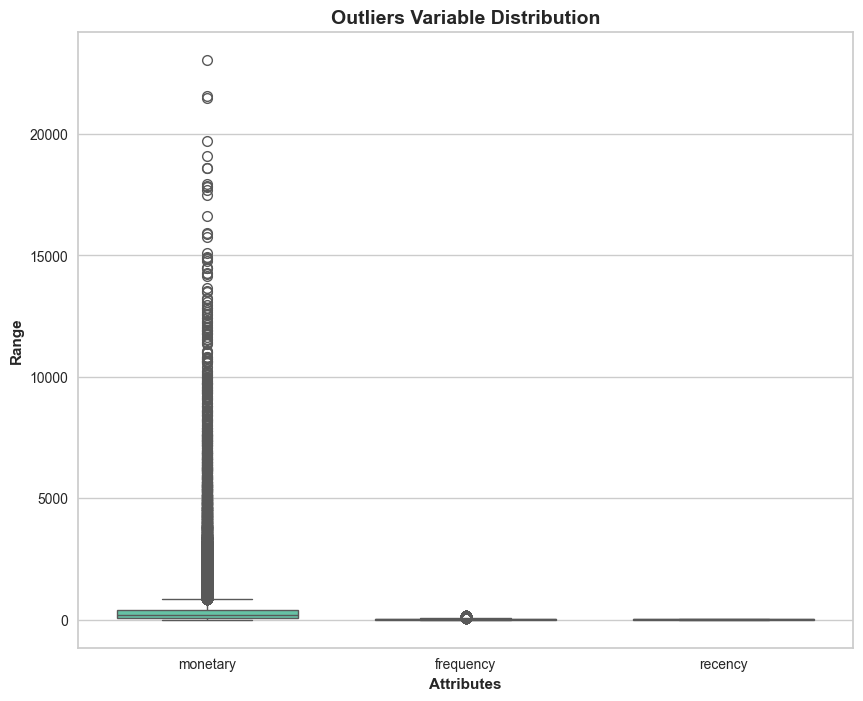

In [21]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['monetary','frequency','recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm_df[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold');

In [22]:
print(rfm_df.shape)
rfm_df_save = rfm_df.copy()

(155498, 4)


In [23]:
# Removing (statistical) outliers for Monetary, Recency, Frequency
for col in ['monetary', 'recency', 'frequency']:
    Q1 = rfm_df[col].quantile(0.05)
    Q3 = rfm_df[col].quantile(0.95)
    IQR = Q3 - Q1
    print(f'col={col} Q1={Q1} Q3={Q3} low={Q1 - 1.5*IQR} high={Q3 + 1.5*IQR}')
    rfm_df = rfm_df[(rfm_df[col] >= Q1 - 1.5*IQR) & (rfm_df[col] <= Q3 + 1.5*IQR)]

col=monetary Q1=22.64 Q3=1209.5514999999998 low=-1757.7272499999995 high=2989.9187499999994
col=recency Q1=0.0 Q3=36.0 low=-54.0 high=90.0
col=frequency Q1=3.0 Q3=88.0 low=-124.5 high=215.5


In [24]:
rfm_df.shape

(153961, 4)

In [25]:
rfm_df[['recency', 'frequency', 'monetary']].describe()

recency  frequency   monetary
count 153,961.00 153,961.00 153,961.00
mean       13.79      26.90     311.09
std        11.62      27.70     392.75
min         0.00       1.00       0.88
25%         4.00       8.00      73.34
50%        11.00      17.00     169.86
75%        23.00      36.00     381.73
max        41.00     150.00   2,987.99

In [26]:
# Save filtered rfm
#rfm_df.to_pickle(rfm_file)

In [27]:
# Filter data with rmf_df restrictions
#filter_dataset(True)

In [28]:
# Rescaling the attributes
# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df[['monetary', 'frequency', 'recency']])
rfm_df_scaled.shape

(153961, 3)

In [29]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Monetary', 'Frequency', 'Recency']
rfm_df_scaled.head()

Monetary  Frequency  Recency
0     -0.16      -0.83    -0.76
1      0.08      -0.86     1.31
2     -0.60      -0.65    -1.19
3      0.07       0.04     1.22
4     -0.48      -0.72    -1.10

Text(0.5, 0, 'Attributes')

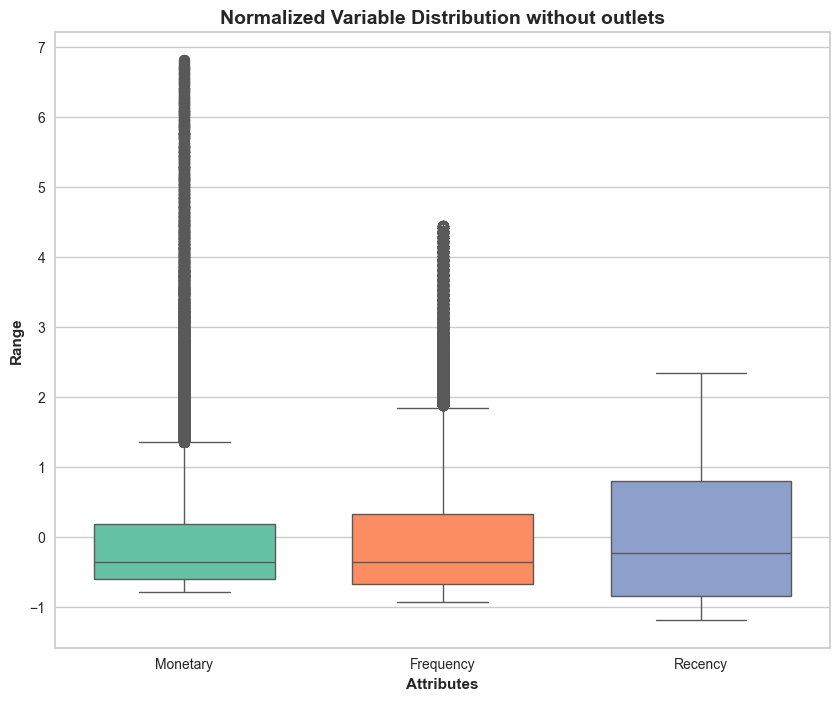

In [30]:
attributes = ['Monetary','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm_df_scaled[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Normalized Variable Distribution without outlets", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

  0%|          | 0/6 [00:00<?, ?it/s]

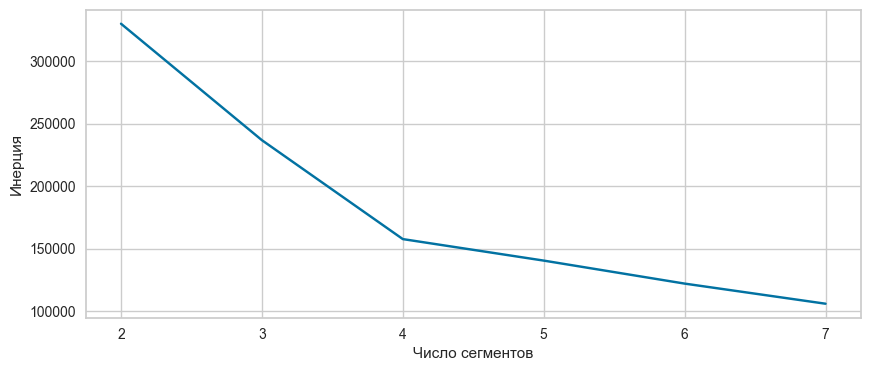

In [31]:
# Elbow-curve/SSD

ssd = []
range_n_clusters = [a for a in range(2,8)]
for num_clusters in tqdm(range_n_clusters):
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
plt.figure(figsize=(10, 4))
plt.xlabel('Число сегментов')
plt.ylabel('Инерция')
plt.plot(range_n_clusters, ssd)

  0%|          | 0/14 [00:00<?, ?it/s]

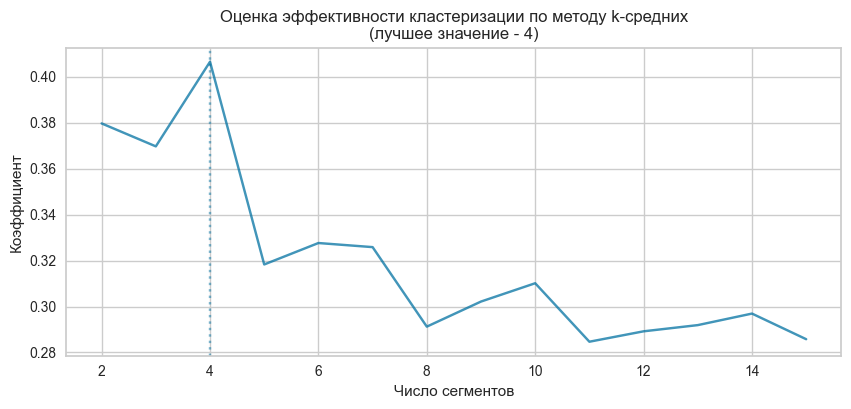

CPU times: total: 29.8 s
Wall time: 26.5 s


In [32]:
%%time
def sil_segs():
    # Silhouette analysis
    x=[]
    y=[]
    data_for_segmentation = rfm_df_scaled.sample(n=10000, random_state=42)

    for num_clusters in tqdm(np.arange(2,16)):
        # intialise kmeans
        kmeans = KMeans(n_clusters=num_clusters, max_iter=100, random_state=42)
        kmeans.fit(data_for_segmentation)
        cluster_labels = kmeans.labels_
        # silhouette score
        silhouette_avg = silhouette_score(data_for_segmentation, cluster_labels)
        #print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
        x.append(num_clusters)
        y.append(silhouette_avg)

    plt.figure(figsize=(10, 4))
    plt.plot(x, y, alpha=0.75)
    plt.xlabel('Число сегментов')
    plt.ylabel('Коэффициент')
    plt.title(f'Оценка эффективности кластеризации по методу k-средних\n(лучшее значение - {x[y.index(max(y))]})')
    plt.axvline(x=x[y.index(max(y))], linestyle='dotted', alpha=0.5)
    plt.show();
sil_segs()

In [33]:
#top_price = dataset[dataset['price']>1000].sort_values(by=['price'],ascending=False)['price'].iloc[0]
top_price = 2574.07
print(f'Самая высокая цена за товар: {top_price}')

Самая высокая цена за товар: 2574.07


## Сколько покупателей посетило сайт?

In [35]:
print (f"Посетителей: {dataset['user_id'].nunique()}, Количество строк в датафрейме: {len(dataset)}")

Посетителей: 155498, Количество строк в датафрейме: 4245389


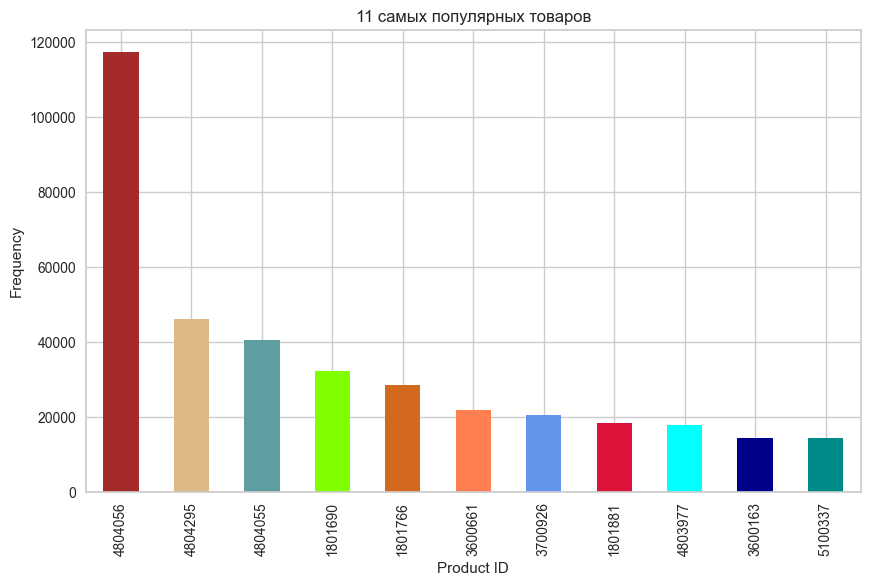

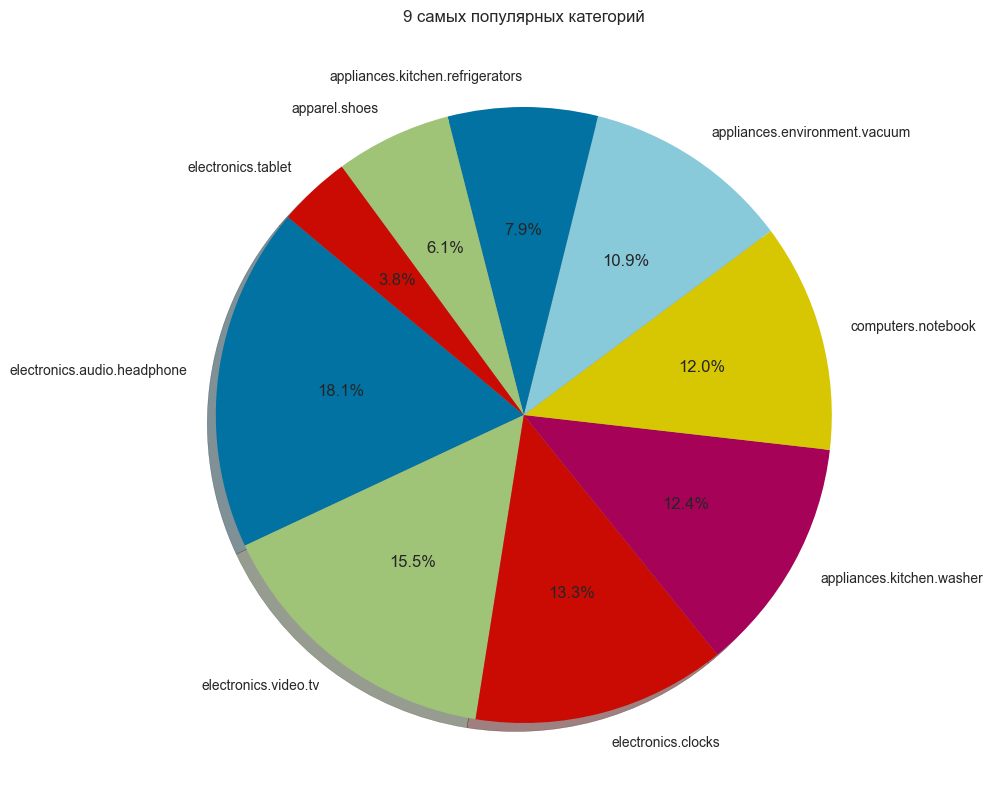

In [36]:
"""
11 товаров были куплены более 100тыс раз. Остальные - менее популярны
"""
NumProd=11
popular_products = dataset['product_id'].value_counts().head(NumProd)
plt.figure(figsize=(10,6))
popular_products.plot(kind='bar', color=custom_color) #'skyblue')
plt.xlabel('Product ID')
plt.ylabel('Frequency')
plt.title(f'{NumProd} самых популярных товаров')
plt.show();

"""
Предварительное изучение данных показало, что 10 и последующие категории
занимают менее 2%, поэтому ограничимся 9-ю
"""
NumCat=9
popular_categories = dataset['category_code'].value_counts().head(NumCat)
plt.figure(figsize=(10,10))
plt.pie(popular_categories, labels=popular_categories.index, autopct='%1.1f%%', startangle=140, shadow=True)
plt.title(f'{NumCat} самых популярных категорий')
plt.show();

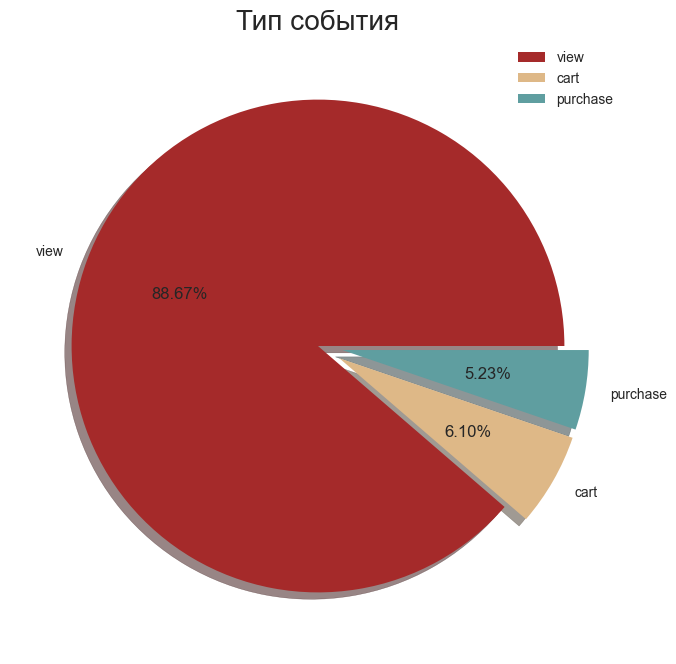

In [37]:
labels = ['view', 'cart', 'purchase']
size = dataset['event_type'].value_counts()
colors = custom_color #['yellowgreen', 'lightskyblue','lightcoral']
explode = [0, 0.1,0.1]

plt.rcParams['figure.figsize'] = (8, 8)
plt.pie(size, colors = colors, explode = explode, labels = labels, shadow = True, autopct = '%.2f%%')
plt.title('Тип события', fontsize = 20)
plt.axis('off')
plt.legend()
plt.show();

## <font color="darkred">Тренд посещаемости без фильтрации. 
Всплеск соответствует "чёрной пятнице".

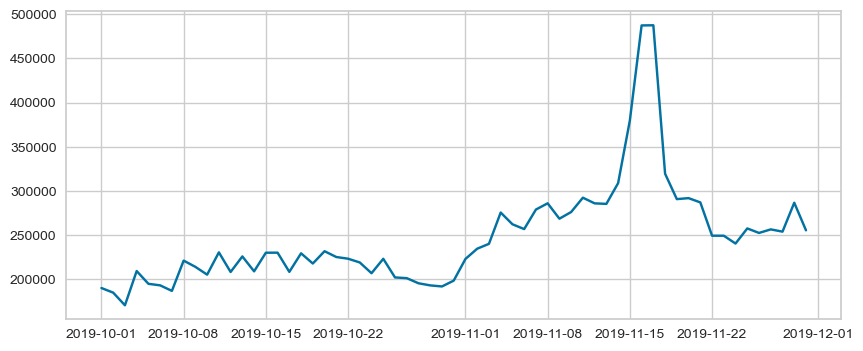

## <font color="darkgreen">Тренд посещаемости по дням
Флуктуирует ли ежедневный трафик?

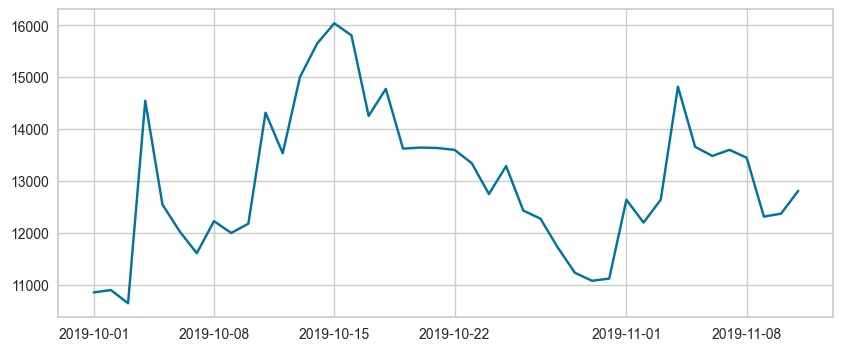

In [41]:
%matplotlib inline
d = dataset.loc[:,['event_time','user_id']]
d['event_time'] = d['event_time'].apply(lambda s: str(s)[0:10])
visitor_by_date = d.drop_duplicates().groupby(['event_time'])['user_id'].agg(['count']).sort_values(by=['event_time'],  ascending=True)
x = pd.Series(visitor_by_date.index.values).apply(lambda s: dt.datetime.strptime(s, '%Y-%m-%d').date())
y = visitor_by_date['count']
plt.rcParams['figure.figsize'] = (20,8)
plt.figure(figsize=(10, 4))
plt.plot(x,y)
plt.show();

# По категориям и продуктам
Какую категорию клиенты выбирают чаще всего? Какой бренд нравится больше всего?

### <font color="darkred">Одна категория сильно выделяется - electronics.smartphone. Исключим её из анализа.

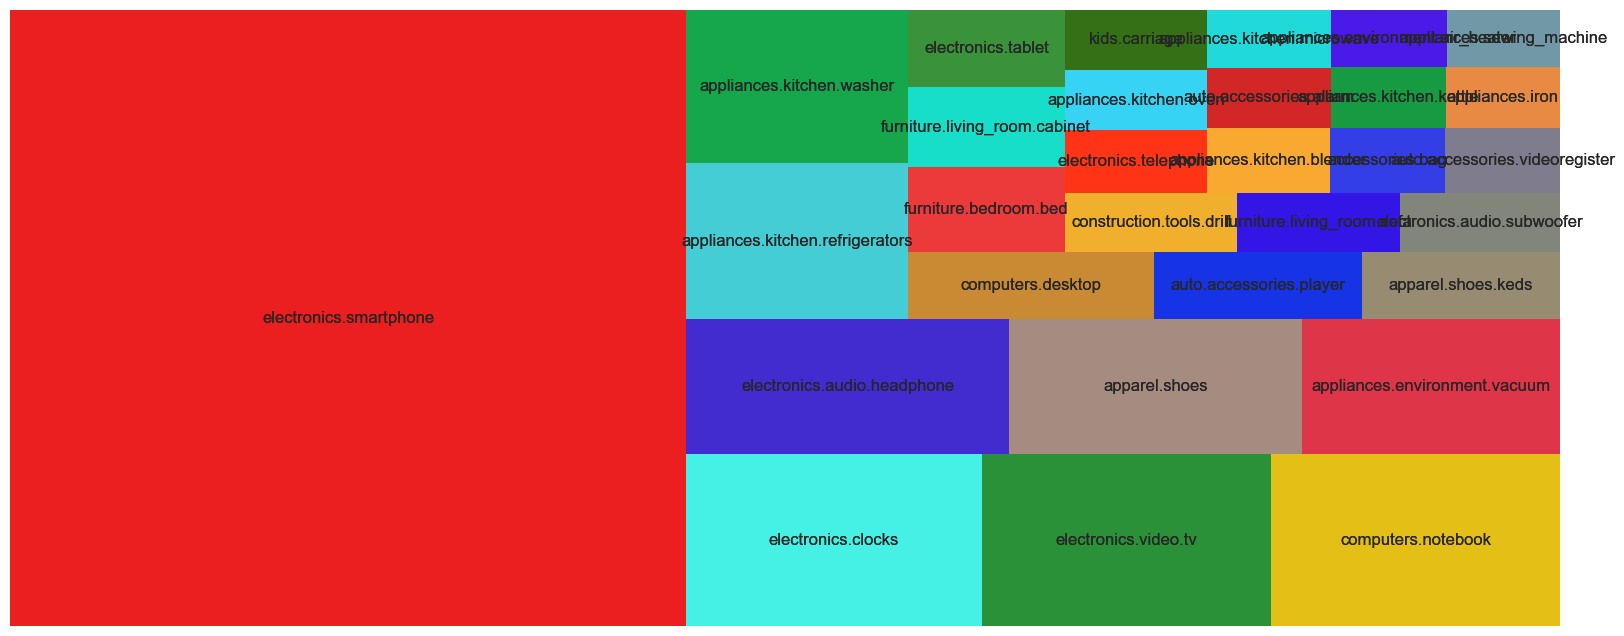

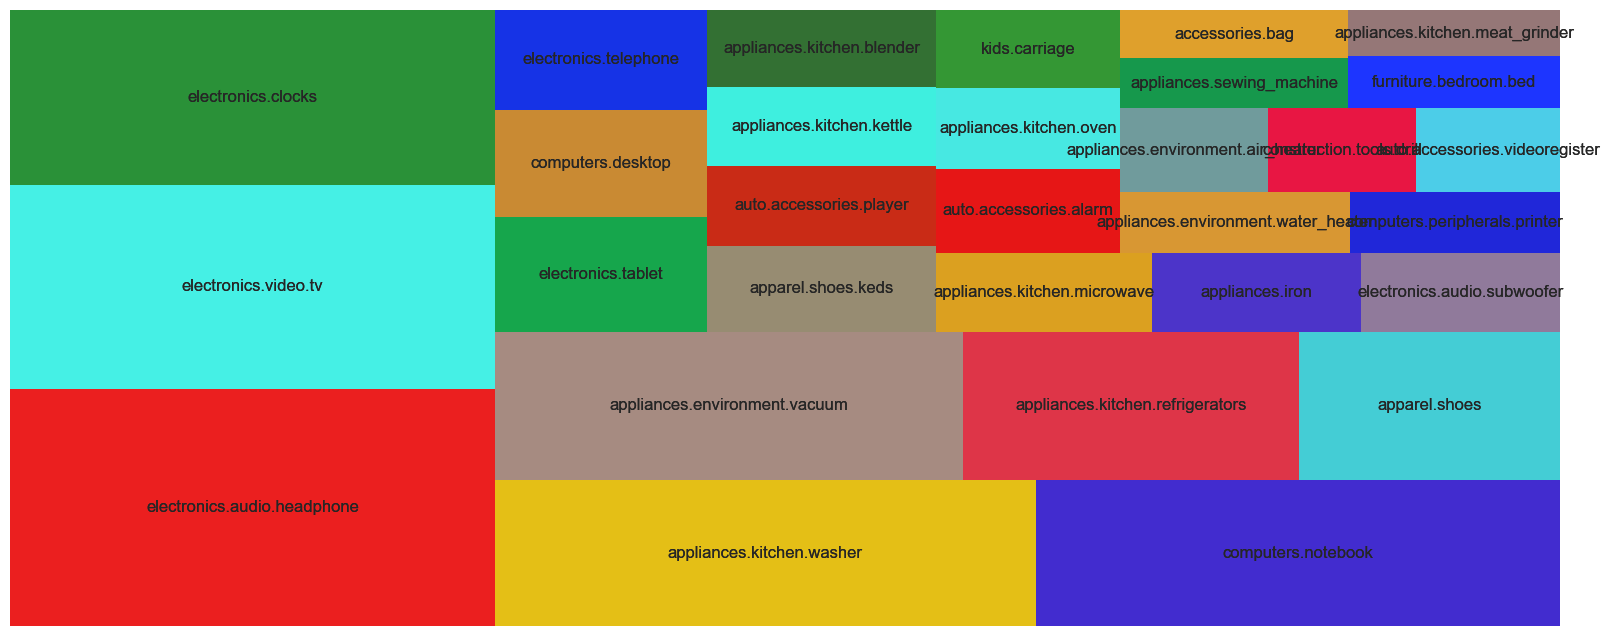

In [45]:
top_category_n = 30
top_category = dataset.loc[:,'category_code'].value_counts()[:top_category_n].sort_values(ascending=False)
squarify.plot(sizes=top_category, label=top_category.index.array, color=custom_color, alpha=.7  )
squarify.plot(sizes=top_category, label=top_category.index.array, color=["red","cyan","green","orange","blue","grey"], alpha=.7  )
plt.axis('off')
plt.show();

## event_type = "purchase", какой товар покупают клиенты?

In [47]:
purchase = dataset.loc[dataset['event_type'] == 'purchase']
purchase = purchase.dropna(axis='rows')
purchase.head()

event_time event_type  product_id  \
442 2019-10-01 00:07:07+00:00   purchase    13800054   
574 2019-10-01 00:09:26+00:00   purchase     4804055   
603 2019-10-01 00:09:54+00:00   purchase     4804056   
672 2019-10-01 00:10:56+00:00   purchase     6200687   
749 2019-10-01 00:12:14+00:00   purchase     4802036   

                         category_code    brand  price    user_id  \
442          furniture.bathroom.toilet  santeri  54.42  555332717   
574        electronics.audio.headphone    apple 189.91  524601178   
603        electronics.audio.headphone    apple 161.98  551377651   
672  appliances.environment.air_heater    oasis  28.03  548691404   
749        electronics.audio.headphone    apple 171.56  533624186   

                             user_session    category_code_level1  \
442  1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f      furniture.bathroom   
574  2af9b570-0942-4dcd-8f25-4d84fba82553       electronics.audio   
603  3c80f0d6-e9ec-4181-8c5c-837a30be2d68       electronics.audio   
672  b67cdbcb-b073-4271-b365-803c6fce53b0  appliances.environment   
749  e5ac3caa-e6d5-4d6b-ae06-2c18cd9ca683       electronics.audio   

    category_code_level2      dow        date  
442               toilet  Tuesday  2019-10-01  
574            headphone  Tuesday  2019-10-01  
603            headphone  Tuesday  2019-10-01  
672           air_heater  Tuesday  2019-10-01  
749            headphone  Tuesday  2019-10-01

In [48]:
print(f'Записей о покупке: {purchase.shape[0]}, уникальных клиентов: {purchase.user_id.nunique()}')

Записей о покупке: 258820, уникальных клиентов: 155498


In [49]:
dataset.columns

Index(['event_time', 'event_type', 'product_id', 'category_code', 'brand',
       'price', 'user_id', 'user_session', 'category_code_level1',
       'category_code_level2', 'dow', 'date'],
      dtype='object')

In [50]:
%%time
# 1min 16s
dataset['date'] = pd.to_datetime(dataset['event_time'])
dataset_min_date = dataset['date'].min()
dataset['event_time'] = (dataset['date'] - dataset_min_date) /  np.timedelta64(1, 's')

CPU times: total: 156 ms
Wall time: 165 ms


In [51]:
if 'date' in dataset.columns:
    dataset.drop(['date'], axis=1, inplace=True)

In [52]:
if 'dow' in dataset.columns:
    dataset.drop(['dow'], axis=1, inplace=True)

In [53]:
for col in tqdm(['event_type', 'category_code_level1', 'category_code_level2', 'category_code', 'brand', 'user_session']):
    if col in dataset.columns:
        dataset[col] = pd.factorize(dataset[col])[0]

  0%|          | 0/6 [00:00<?, ?it/s]

In [54]:
df = dataset# .sample(dataset.shape[0]//10)
df.head()

event_time  event_type  product_id  category_code  brand  price  \
5         0.00           0     1480613              0      0 908.62   
22       17.00           0     1480714              0      0 921.49   
45       30.00           0     3601505              1      1 463.15   
47       31.00           0     3600575              1      2 275.37   
50       32.00           0     1701111              2      3 514.79   

      user_id  user_session  category_code_level1  category_code_level2  
5   512742880             0                     0                     0  
22  512742880             0                     0                     0  
45  526631741             1                     1                     1  
47  554754045             2                     1                     1  
50  547028884             3                     2                     2

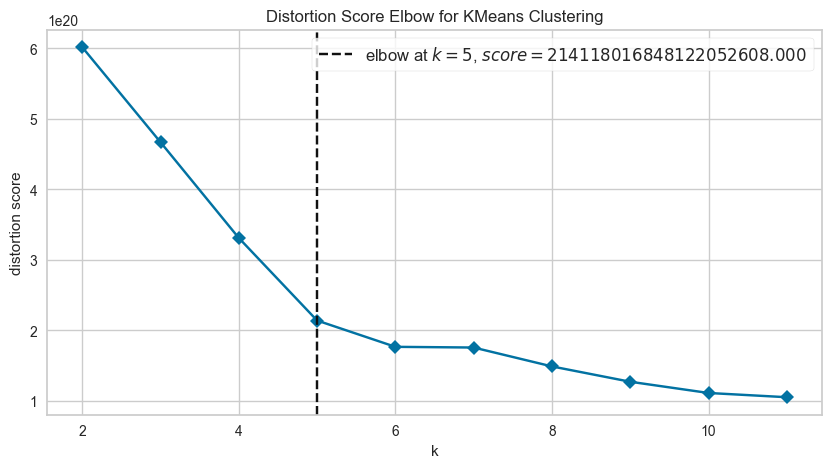

CPU times: total: 1min 54s
Wall time: 44.7 s


In [55]:
%%time
# 48.4s
# Применим метод K-средних. Он хорошо масштабируется для большого количества образцов 
# и используется в широком диапазоне областей применения во многих различных областях.
plt.figure(figsize=(10,5))
model = KMeans()
elbow = KElbowVisualizer(model, k=(2,12), timings = False,  force_model=True)
elbow.fit(df) #, timings = False
elbow.show();

In [56]:
# Применить метод Birch - "эффективный метод кластеризации данных для больших баз данных" - не удалось
#plt.figure(figsize=(10,5))
#model = Birch()
#elbow = KElbowVisualizer(model, k=(2,12), timings = False,  force_model=True)
#elbow.fit(df) #, timings = False
#elbow.show();
# MemoryError: Unable to allocate 2.21 TiB for an array with shape (303685028130,) and data type float64

In [57]:
#sns.jointplot(x="category_id", y="product_id", data=df, marginal_kws={"bins": 100});

In [58]:
%%time
# Перечитываем данные, т.к. это быстрее, чем выполнить обратную категоризацию исходных данных.
dataset = read_data(True)
filter_dataset(True)
# Дополнительная фильтрация датасета, с учётом выбросов в RFM
#dataset = dataset[dataset['user_id'].isin(rfm_df['user_id'])]
dataset.head()

Reading data from cache file
Дополнительная фильтрация данных на основании модели RFM
(4245389, 11)
CPU times: total: 2.03 s
Wall time: 2.03 s


event_time event_type  product_id  \
5   2019-10-01 00:00:05 UTC       view     1480613   
22  2019-10-01 00:00:22 UTC       view     1480714   
45  2019-10-01 00:00:35 UTC       view     3601505   
47  2019-10-01 00:00:36 UTC       view     3600575   
50  2019-10-01 00:00:37 UTC       view     1701111   

                    category_code             brand  price    user_id  \
5               computers.desktop            pulser 908.62  512742880   
22              computers.desktop            pulser 921.49  512742880   
45      appliances.kitchen.washer           samsung 463.15  526631741   
47      appliances.kitchen.washer  hotpoint-ariston 275.37  554754045   
50  computers.peripherals.monitor              acer 514.79  547028884   

                            user_session   category_code_level1  \
5   0d0d91c2-c9c2-4e81-90a5-86594dec0db9              computers   
22  0d0d91c2-c9c2-4e81-90a5-86594dec0db9              computers   
45  5ec9bd77-beef-443e-b987-62ffb55b8132     appliances.kitchen   
47  bd0302ef-c5ca-4b6a-b916-95cc2840c72c     appliances.kitchen   
50  3ea7c620-a8d7-45c5-9ced-2e9874e2f549  computers.peripherals   

   category_code_level2      dow  
5               desktop  Tuesday  
22              desktop  Tuesday  
45               washer  Tuesday  
47               washer  Tuesday  
50              monitor  Tuesday

In [59]:
# Стандартизировано с использованием только частоты и денежных единиц.
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['frequency', 'monetary']])
#print(rfm_scaled.head())

# Кластеризация K-средних
kmeans = KMeans(n_clusters=5, random_state=42)
rfm_df['cluster'] = kmeans.fit_predict(rfm_scaled)

rfm_df.head()

user_id  recency  frequency  monetary  cluster
0  253299396        5          4    246.85        1
1  303160429       29          3    340.59        1
2  310402868        0          9     77.22        1
3  340041246       28         28    339.70        1
4  378784732        1          7    122.78        1

In [60]:
rfm_df.groupby(by='cluster').count()

user_id  recency  frequency  monetary
cluster                                       
0           5576     5576       5576      5576
1          87376    87376      87376     87376
2          28787    28787      28787     28787
3          10769    10769      10769     10769
4          21453    21453      21453     21453

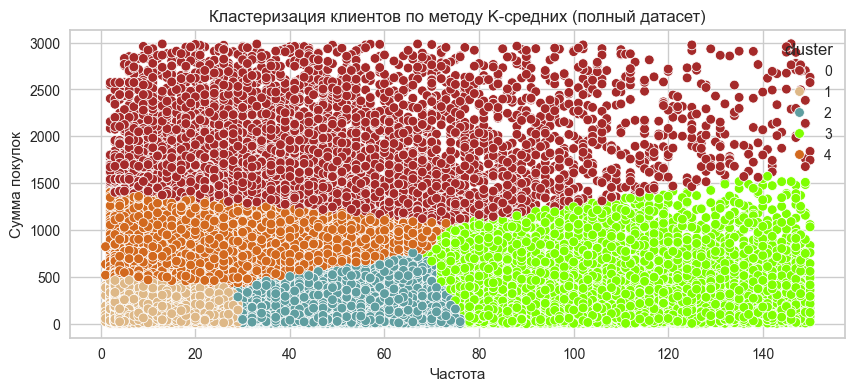

In [61]:
# Визуализируем результаты кластеризации
plt.figure(figsize=(10, 4))
sns.scatterplot(x='frequency', y='monetary', hue='cluster', data=rfm_df, palette=custom_color, legend='full')
plt.title('Кластеризация клиентов по методу K-средних (полный датасет)')
plt.xlabel('Частота')
plt.ylabel('Сумма покупок')
plt.show();

In [62]:
user_and_price = purchase[['user_id','price']]

  0%|          | 0/40333 [00:00<?, ?it/s]

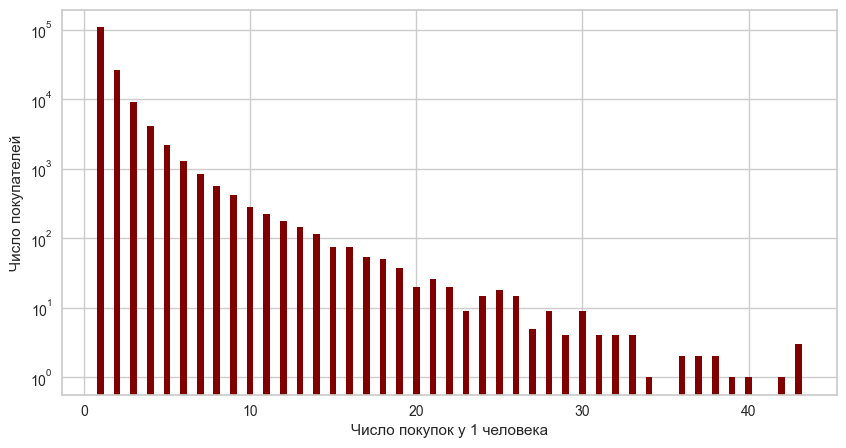

In [63]:
data = user_and_price.groupby(by='user_id').count()
x = data['price'].unique()
y = [data[data['price']==xval].shape[0] for xval in x]
data = user_and_price.groupby(by='user_id').sum()
xp = data['price'].unique().tolist()
xp.sort()
yp = [data[data['price']==xval].shape[0] for xval in tqdm(xp)]
fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.xlabel('Число покупок у 1 человека')
plt.ylabel('Число покупателей')
plt.bar(x, y, color ='maroon', width = 0.4, log=True)
plt.show();

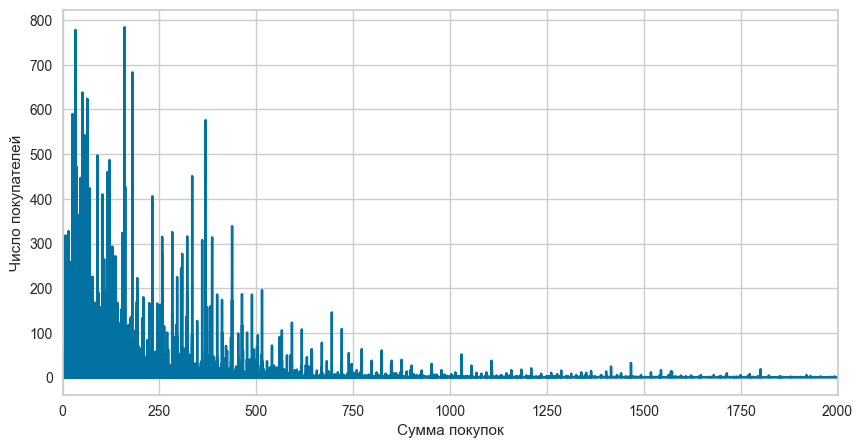

In [64]:
fig = plt.figure(figsize = (10, 5))
# creating the bar plot
plt.xlabel('Сумма покупок')
plt.ylabel('Число покупателей')
#plt.yscale('log')
plt.plot(xp, yp)
plt.xlim([0, 2000])

plt.show();

In [65]:
user_and_price.groupby(by='user_id').count().sort_values('price', ascending=False).head(5)

price
user_id         
513053457     43
530206193     43
536654291     43
519440228     42
559225554     40

In [66]:
#purchase[purchase['user_id']==532746228]
#purchase[purchase['price']>2000].sort_values(by=['price'],ascending=False)

In [67]:
purchase.head()

event_time event_type  product_id  \
442 2019-10-01 00:07:07+00:00   purchase    13800054   
574 2019-10-01 00:09:26+00:00   purchase     4804055   
603 2019-10-01 00:09:54+00:00   purchase     4804056   
672 2019-10-01 00:10:56+00:00   purchase     6200687   
749 2019-10-01 00:12:14+00:00   purchase     4802036   

                         category_code    brand  price    user_id  \
442          furniture.bathroom.toilet  santeri  54.42  555332717   
574        electronics.audio.headphone    apple 189.91  524601178   
603        electronics.audio.headphone    apple 161.98  551377651   
672  appliances.environment.air_heater    oasis  28.03  548691404   
749        electronics.audio.headphone    apple 171.56  533624186   

                             user_session    category_code_level1  \
442  1dea3ee2-2ded-42e8-8e7a-4e2ad6ae942f      furniture.bathroom   
574  2af9b570-0942-4dcd-8f25-4d84fba82553       electronics.audio   
603  3c80f0d6-e9ec-4181-8c5c-837a30be2d68       electronics.audio   
672  b67cdbcb-b073-4271-b365-803c6fce53b0  appliances.environment   
749  e5ac3caa-e6d5-4d6b-ae06-2c18cd9ca683       electronics.audio   

    category_code_level2      dow        date  
442               toilet  Tuesday  2019-10-01  
574            headphone  Tuesday  2019-10-01  
603            headphone  Tuesday  2019-10-01  
672           air_heater  Tuesday  2019-10-01  
749            headphone  Tuesday  2019-10-01

In [68]:
dataset.head(5)

event_time event_type  product_id  \
5   2019-10-01 00:00:05 UTC       view     1480613   
22  2019-10-01 00:00:22 UTC       view     1480714   
45  2019-10-01 00:00:35 UTC       view     3601505   
47  2019-10-01 00:00:36 UTC       view     3600575   
50  2019-10-01 00:00:37 UTC       view     1701111   

                    category_code             brand  price    user_id  \
5               computers.desktop            pulser 908.62  512742880   
22              computers.desktop            pulser 921.49  512742880   
45      appliances.kitchen.washer           samsung 463.15  526631741   
47      appliances.kitchen.washer  hotpoint-ariston 275.37  554754045   
50  computers.peripherals.monitor              acer 514.79  547028884   

                            user_session   category_code_level1  \
5   0d0d91c2-c9c2-4e81-90a5-86594dec0db9              computers   
22  0d0d91c2-c9c2-4e81-90a5-86594dec0db9              computers   
45  5ec9bd77-beef-443e-b987-62ffb55b8132     appliances.kitchen   
47  bd0302ef-c5ca-4b6a-b916-95cc2840c72c     appliances.kitchen   
50  3ea7c620-a8d7-45c5-9ced-2e9874e2f549  computers.peripherals   

   category_code_level2      dow  
5               desktop  Tuesday  
22              desktop  Tuesday  
45               washer  Tuesday  
47               washer  Tuesday  
50              monitor  Tuesday

## Какие бренды чаще покупают?

In [70]:
top_sellers = purchase.groupby('brand')['brand'].agg(['count']).sort_values('count', ascending=False)
top_sellers.head(20)
#top_sellers.plot(kind='pie', y='count', autopct='%1.1f%%', labeldistance=1.2, pctdistance=1.07);

count
brand          
samsung   34736
apple     34674
xiaomi     9660
lg         9196
acer       7826
elenberg   6540
artel      6427
indesit    6078
lenovo     5361
bosch      4685
beko       4497
hp         4187
haier      3657
casio      3440
tefal      3081
midea      3013
vitek      2830
dauscher   2744
redmond    2674
starline   2413

# Предсказать будет ли куплен товар, добавленный в корзину или нет
### Разработка функций

Реструктурируем данные для использования в модели машинного обучения. В этом случае ориентируюмся только на те данные, когда клиенты «положили» товар в корзину.

Кроме того, добавим несколько новых функций в набор обучающих данных:

- Category_code_level1: категория
- Category_code_level2: подкатегория
- event_weekday: день недели события.
- Activity_count: количество активности в этом сеансе.
- is_purchased: куплен ли товар, помещенный в корзину.

Таким образом, набор обучающих данных содержит каждую недублированную транзакцию корзины (в течение одного сеанса сохраняем только одну запись для конкретного продукта в корзине) с вышеупомянутой новой функцией. Используем эти функции, включая первоначальную цену и бренд, чтобы предсказать, купят ли клиенты в конечном итоге товар из корзины.

In [72]:
df_targets = dataset.loc[dataset["event_type"].isin(["cart","purchase"])].drop_duplicates(subset=['event_type', 'product_id','price', 'user_id','user_session'])
df_targets["is_purchased"] = np.where(df_targets["event_type"]=="purchase",1,0)
df_targets["is_purchased"] = df_targets.groupby(["user_session","product_id"])["is_purchased"].transform("max")
df_targets = df_targets.loc[df_targets["event_type"]=="cart"].drop_duplicates(["user_session","product_id","is_purchased"])
df_targets['event_weekday'] = df_targets['event_time'].apply(lambda s: str(dt.datetime.strptime(str(s)[0:10], "%Y-%m-%d").weekday()))
df_targets.dropna(how='any', inplace=True)
df_targets["category_code_level1"] = df_targets["category_code"].str.rsplit(".",n=1,expand=True)[0].astype('category')
df_targets["category_code_level2"] = df_targets["category_code"].str.rsplit(".",n=1,expand=True)[1].astype('category')

In [73]:
cart_purchase_users = dataset.loc[dataset["event_type"].isin(["cart","purchase"])].drop_duplicates(subset=['user_id'])
cart_purchase_users.dropna(how='any', inplace=True)
cart_purchase_users_all_activity = dataset.loc[dataset['user_id'].isin(cart_purchase_users['user_id'])]

**Подсчитываем активность в сессии**

In [75]:
%%time
activity_in_session = cart_purchase_users_all_activity.groupby(['user_session'])['event_type'].count().reset_index()
activity_in_session = activity_in_session.rename(columns={"event_type": "activity_count"})
#del d # free memory
df_targets = df_targets.merge(activity_in_session, on='user_session', how='left')
df_targets['activity_count'] = df_targets['activity_count'].fillna(0)

CPU times: total: 2.95 s
Wall time: 2.96 s


In [76]:
df_targets.head(5)

event_time event_type  product_id  \
0  2019-10-01 00:11:00 UTC       cart     4804056   
1  2019-10-01 02:21:04 UTC       cart     1500021   
2  2019-10-01 02:21:49 UTC       cart     5100719   
3  2019-10-01 02:23:15 UTC       cart     8800448   
4  2019-10-01 02:30:36 UTC       cart     4804295   

                   category_code    brand  price    user_id  \
0    electronics.audio.headphone    apple 161.98  533624186   
1  computers.peripherals.printer    epson 116.73  513489079   
2             electronics.clocks  samsung 151.61  549614436   
3          electronics.telephone    nokia  43.66  518494067   
4    electronics.audio.headphone   xiaomi  23.13  513684529   

                           user_session   category_code_level1  \
0  e5ac3caa-e6d5-4d6b-ae06-2c18cd9ca683      electronics.audio   
1  63de1120-9d48-45d0-b024-500d1b95d71f  computers.peripherals   
2  129d379f-0137-4bd5-bf30-90c4c7bef7c8            electronics   
3  521e7934-57af-49c6-a96f-b1b4676b7d39            electronics   
4  5fdc8eaa-8bcb-427f-a2b4-6fb50181aee6      electronics.audio   

  category_code_level2      dow  is_purchased event_weekday  activity_count  
0            headphone  Tuesday             0             1               4  
1              printer  Tuesday             1             1               8  
2               clocks  Tuesday             1             1               4  
3            telephone  Tuesday             1             1               6  
4            headphone  Tuesday             1             1               3

## Передискретизация обучающего набора

In [78]:
is_purchase_set = df_targets[df_targets['is_purchased']== 1]
is_purchase_set.shape[0]

103454

In [79]:
not_purchase_set = df_targets[df_targets['is_purchased']== 0]
not_purchase_set.shape[0]

44937

In [80]:
n_samples = int(not_purchase_set.shape[0] * 0.8) #240000
is_purchase_downsampled = resample(is_purchase_set,
                                replace = False, 
                                n_samples = n_samples,
                                random_state = 27)
not_purchase_set_downsampled = resample(not_purchase_set,
                                replace = False,
                                n_samples = n_samples,
                                random_state = 27)

In [81]:
downsampled = pd.concat([is_purchase_downsampled, not_purchase_set_downsampled])
downsampled['is_purchased'].value_counts()

is_purchased
1    35949
0    35949
Name: count, dtype: int64

In [82]:
features = downsampled.loc[:,['brand', 'price', 'event_weekday', 'category_code_level1', 'category_code_level2', 'activity_count']]
features = downsampled.loc[:,['brand', 'price', 'event_weekday', 'activity_count']]

## Кодируем категориальные переменные

In [84]:
features.loc[:,'brand'] = LabelEncoder().fit_transform(downsampled.loc[:,'brand'].copy())
features.loc[:,'event_weekday'] = LabelEncoder().fit_transform(downsampled.loc[:,'event_weekday'].copy())
features.loc[:,'category_code_level1'] = LabelEncoder().fit_transform(downsampled.loc[:,'category_code_level1'].copy())
features.loc[:,'category_code_level2'] = LabelEncoder().fit_transform(downsampled.loc[:,'category_code_level2'].copy())

is_purchased = LabelEncoder().fit_transform(downsampled['is_purchased'])
features.head()

brand  price event_weekday  activity_count  category_code_level1  \
67755     39 617.21             6               4                    14   
134532   306  27.72             6               5                    15   
50732    576  43.50             3               7                    14   
145948   524 140.11             0               4                     7   
47519    253 463.31             2              20                    18   

        category_code_level2  
67755                     16  
134532                    37  
50732                     94  
145948                   109  
47519                    103

In [85]:
features['brand'] = features['brand'].astype('category')
features['event_weekday'] = features['event_weekday'].astype('category')

## Разделяем наборы

In [87]:
X_train, X_test, y_train, y_test = train_test_split(features, 
                                                    is_purchased, 
                                                    test_size = 0.3, 
                                                    random_state = 42)

## Обучаем модель

In [89]:
#cat_features = ['brand', 'event_weekday']

model = XGBClassifier(learning_rate=0.1, enable_categorical=True, max_depth=6, n_estimators=200)
model.fit(X_train, y_train, verbose=True)
y_pred = model.predict(X_test)

In [90]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print("Precision:",metrics.precision_score(y_test, y_pred))
print("Recall:",metrics.recall_score(y_test, y_pred))
print("fbeta:",metrics.fbeta_score(y_test, y_pred, average='weighted', beta=0.5))

Accuracy: 0.6067222994900324
Precision: 0.5890104808877928
Recall: 0.7081441675159826
fbeta: 0.6061814934727788


## Значимость признаков

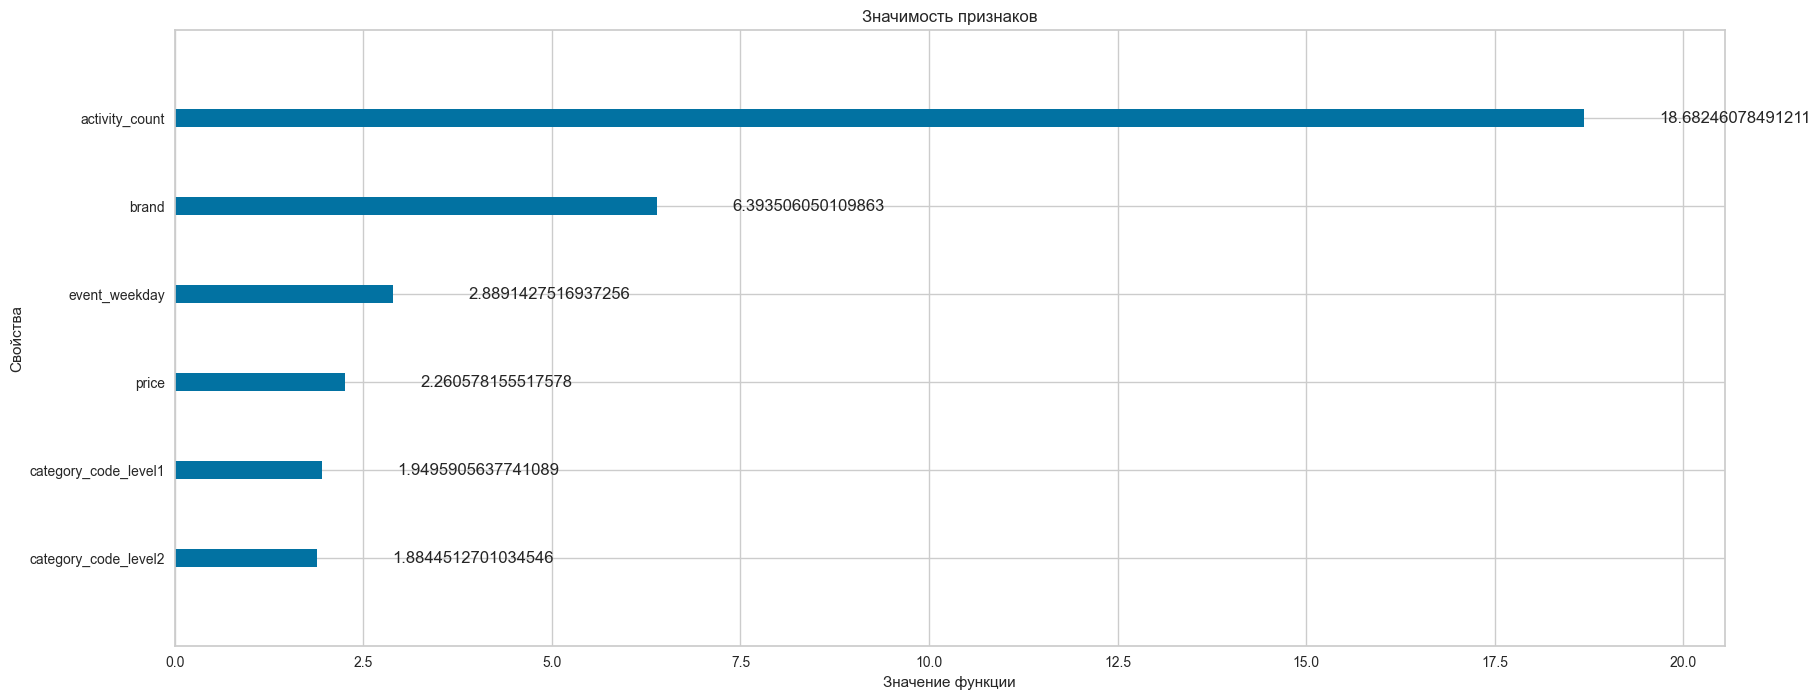

In [92]:
plot_importance(model, max_num_features=10, importance_type ='gain', title='Значимость признаков', ylabel='Свойства', xlabel='Значение функции')
plt.rcParams['figure.figsize'] = (10,5)
plt.show()

In [93]:
df_targets = dataset.loc[dataset["event_type"].isin(["cart","purchase"])].drop_duplicates(subset=['event_type', 'product_id','price', 'user_id','user_session'])
df_targets["is_purchased"] = np.where(df_targets["event_type"]=="purchase",1,0)
df_targets["is_purchased"] = df_targets.groupby(["user_session","product_id"])["is_purchased"].transform("max")
df_targets = df_targets.loc[df_targets["event_type"]=="cart"].drop_duplicates(["user_session","product_id","is_purchased"])
df_targets['event_weekday'] = df_targets['event_time'].apply(lambda s: str(dt.datetime.strptime(str(s)[0:10], "%Y-%m-%d").weekday()))
df_targets.dropna(how='any', inplace=True)
df_targets["category_code_level1"] = df_targets["category_code"].str.split(".",expand=True)[0].astype('category')
df_targets["category_code_level2"] = df_targets["category_code"].str.split(".",expand=True)[1].astype('category')
cart_purchase_users = dataset.loc[dataset["event_type"].isin(["cart","purchase"])].drop_duplicates(subset=['user_id'])
cart_purchase_users.dropna(how='any', inplace=True)
cart_purchase_users_all_activity = dataset.loc[dataset['user_id'].isin(cart_purchase_users['user_id'])]

is_purchase_set = df_targets[df_targets['is_purchased']== 1]
is_purchase_set.shape[0]

103454

In [94]:
not_purchase_set = df_targets[df_targets['is_purchased']== 0]
not_purchase_set.shape[0]

44937

In [95]:
top_category_codes = dataset['category_code'].value_counts().head(10)

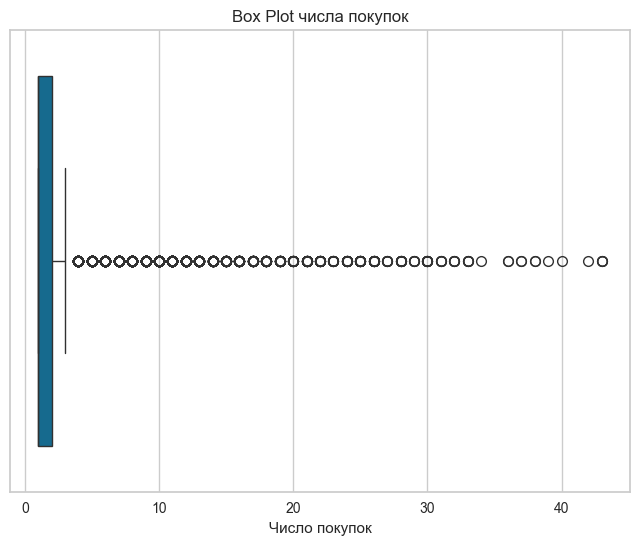

In [96]:
# Фильтровать только строки «покупки»
purchase_df = dataset[dataset['event_type'] == 'purchase']

# Группируем по user_id, вычисляем число и сортируем по убыванию
purchase_counts = purchase_df.groupby('user_id')['event_type'].count().reset_index(name='purchase_count').sort_values(by='purchase_count', ascending=False)

# Визуализация
plt.figure(figsize=(8, 6))
sns.boxplot(x=purchase_counts['purchase_count'])
plt.title('Box Plot числа покупок')
plt.xlabel('Число покупок')
plt.show();

In [97]:
%%time

chunk = dataset
dataset_stats(chunk)
chunk['event_time'] = pd.to_datetime(chunk['event_time'], utc=True)
chunk['year'] = chunk['event_time'].dt.year
chunk['month'] = chunk['event_time'].dt.month
chunk['event_time'] = chunk['event_time'].dt.date
chunk = chunk.groupby(['year', 'month', 'category_code', 'event_type'])\
                .agg({'user_id': 'nunique', 'product_id': 'count'})\
                .rename(columns={'user_id': 'unique_users', 'product_id': 'event_count'})
funnel = chunk.groupby(['year', 'month', 'category_code', 'event_type'])\
               .agg({'unique_users': 'sum', 'event_count': 'sum'})\
               .reset_index()

"""
def process_chunk(chunk):
    # Нормализуем дату и извлечем год, месяц
    chunk['event_time'] = pd.to_datetime(chunk['event_time'], utc=True)
    chunk['year'] = chunk['event_time'].dt.year
    chunk['month'] = chunk['event_time'].dt.month
    chunk['event_time'] = chunk['event_time'].dt.date
    
    # Группируем данные в чанке
    return chunk.groupby(['year', 'month', 'category_code', 'event_type'])\
                .agg({'user_id': 'nunique', 'product_id': 'count'})\
                .rename(columns={'user_id': 'unique_users', 'product_id': 'event_count'})

# Инициализация пустого DataFrame для сохранения результатов после каждого чанка
funnel = pd.DataFrame()

# Постепенное чтение файла по частям и обработка каждой порции
for chunk in pd.read_csv(file_oct, chunksize=chunksize):
    funnel_chunk = process_chunk(chunk)
    
    # Сброс индекса для дальнейшей конкатенации
    funnel_chunk = funnel_chunk.reset_index()
    
    # Конкатенация с общим DataFrame
    funnel = pd.concat([funnel, funnel_chunk], ignore_index=True)

# Группирование окончательных данных для учета возможных дубликатов при группировке чанков
funnel = funnel.groupby(['year', 'month', 'category_code', 'event_type'])\
               .agg({'unique_users': 'sum', 'event_count': 'sum'})\
               .reset_index()

# Вывод получившегося датасета на экран

chunk.groupby(['year', 'month', 'category_code', 'event_type'])\
                .agg({'user_id': 'nunique', 'product_id': 'count'})\
                .rename(columns={'user_id': 'unique_users', 'product_id': 'event_count'})

funnel = chunk.groupby(['year', 'month', 'category_code', 'event_type'])\
               .agg({'unique_users': 'sum', 'event_count': 'sum'})\
               .reset_index()
"""
funnel.head()

CPU times: total: 1min 19s
Wall time: 1min 19s


year  month         category_code event_type  unique_users  event_count
0  2019     10       accessories.bag       cart           150          304
1  2019     10       accessories.bag   purchase           732          931
2  2019     10       accessories.bag       view          4848        28290
3  2019     10  accessories.umbrella       cart             2            2
4  2019     10  accessories.umbrella   purchase            20           23

In [98]:
dataset_stats(funnel)

In [99]:
purchase = dataset[dataset['event_type'] == 'purchase']

# Группировка по user_id для расчёта показателей
customer_metrics = purchase.groupby('user_id').agg(
    total_revenue=pd.NamedAgg(column='price', aggfunc='sum'),  # Общая выручка
    total_products=pd.NamedAgg(column='product_id', aggfunc='count'),  # Общее количество купленных товаров
    average_check=pd.NamedAgg(column='price', aggfunc='mean')  # Средний чек
)

# Расчёт среднего количества товаров в одной покупке
customer_metrics['average_products_per_purchase'] = customer_metrics['total_products'] / customer_metrics['total_products'].count()

# Сброс индекса, если требуется преобразовать user_id из индекса в столбец
customer_metrics.reset_index(inplace=True)

# Отображаем получившиеся данные
customer_metrics.head()

user_id  total_revenue  total_products  average_check  \
0  253299396         246.85               1         246.85   
1  303160429         340.59               1         340.59   
2  310402868          77.22               1          77.22   
3  340041246         339.70               1         339.70   
4  378784732         122.78               1         122.78   

   average_products_per_purchase  
0                           0.00  
1                           0.00  
2                           0.00  
3                           0.00  
4                           0.00

In [100]:
%%time
# 1min 13s
# Уменьшим размер подвыборки
sample_size = 50000
purchases_sample = purchase.copy() # .sample(n=sample_size, random_state=42)

# Создадим reader и загрузим данные
reader = Reader(rating_scale=(purchases_sample['price'].min(), purchases_sample['price'].max()))
data = Dataset.load_from_df(purchases_sample[['user_id', 'product_id', 'price']], reader)

def show_res(res):
    print("\n               Fold_1   Fold_2   Fold_3     Mean      Std")
    print('-' * 57)
    for key in list(res.keys()):
        print(f"{key:9s}     {res[key][0]:7.2f}  {res[key][1]:7.2f}  {res[key][2]:7.2f}"
              f"  {np.mean(res[key]):7.2f}  {np.std(res[key]):7.2f}")
    print('\n')

# Инициализируем модели и проводим кросс-валидацию
try:
    svd = SVD()
    res = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=3)
    show_res(res)
except MemoryError:
    print("Недостаточно памяти для SVD.")

try:
    # Укажем параметры для уменьшения использования памяти
    sim_options = {
        'name': 'MSD',
        'user_based': False  # Вычисляем сходство на основе элементов
    }
    knn_basic = KNNBasic(sim_options=sim_options)
    res = cross_validate(knn_basic, data, measures=['RMSE', 'MAE'], cv=3)
    show_res(res)
except MemoryError:
    print("Недостаточно памяти для KNNBasic.")

try:
    nmf = NMF()
    res = cross_validate(nmf, data, measures=['RMSE', 'MAE'], cv=3)
    show_res(res)
except MemoryError:
    print("Недостаточно памяти для NMF.")


               Fold_1   Fold_2   Fold_3     Mean      Std
---------------------------------------------------------
test_rmse     2293.54  2294.57  2290.01  2292.71     1.95
test_mae      2219.38  2221.75  2212.67  2217.94     3.84
fit_time         2.85     2.94     3.03     2.94     0.07
test_time        0.75     0.75     0.91     0.80     0.07


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.

               Fold_1   Fold_2   Fold_3     Mean      Std
---------------------------------------------------------
test_rmse      195.00   197.88   196.28   196.39     1.18
test_mae       114.18   114.69   114.56   114.48     0.22
fit_time         2.34     2.62     2.68     2.55     0.15
test_time        1.10     0.90     1.16     1.05     0.11



               Fold_1   Fold_2   Fold_3     Mean      Std
--------------------

In [101]:
def show_pie(rfm_df):
    data = rfm_df.groupby('cluster')['cluster'].count()
    data_size = len(data)
    labels=data.index.tolist()
    #print(labels)
    data_size = len(data)
    #labels = range(0, data_size)
    #print(labels)
    sizes = data
    fig, ax = plt.subplots()
    #colors = sns.color_palette('viridis')
    #ax.set(rc={'figure.figsize':(11.7,8.27)})
    ax.pie(sizes, labels=labels, colors=custom_color)#, autopct='%1.3f%%', pctdistance=1.5)

### RFM (Recency, Frequency, Monetary)

In [103]:
rfm_df = rfm(dataset)
"""
dataset['event_time'] = pd.to_datetime(dataset['event_time'])
# Извлечь только год, месяц и дату
dataset['date'] = dataset['event_time'].dt.date

# Вычислить Recency
max_date =dataset['event_time'].max()
recency_df = dataset.groupby('user_id')['event_time'].max().reset_index(name='recency')
recency_df['recency'] = (max_date - recency_df['recency']).dt.days

# Расчет частоты различных событий
event_types = ['purchase', 'cart', 'view']
frequency_df = dataset[dataset['event_type'].isin(event_types)].groupby('user_id')['event_type'].count().reset_index(name='frequency')

# Денежные расчеты
monetary_df = dataset[dataset['event_type'] == 'purchase'].groupby('user_id')['price'].sum().reset_index(name='monetary')

# RFM Создаём фрейм данных
rfm_df = pd.merge(recency_df, frequency_df, on='user_id')
rfm_df = pd.merge(rfm_df, monetary_df, on='user_id')

#print(rfm_df)
"""

# Стандартизировано с использованием только частоты и денежных единиц.
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_df[['frequency', 'monetary']])
"""
# Кластеризация K-средних
for k in range(4, 7):
    kmeans = KMeans(n_clusters=k, random_state=42)
    rfm_df['cluster'] = kmeans.fit_predict(rfm_scaled)

    #print(rfm_df)

    # Визуализируем результаты кластеризации
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='frequency', y='monetary', hue='cluster', data=rfm_df, legend='full', palette=custom_color)
    plt.title(f'K-Means Clustering of Customers (k={k})')
    plt.xlabel('Frequency')
    plt.ylabel('Monetary')
    plt.show()
    show_pie(rfm_df);
"""

"\n# Кластеризация K-средних\nfor k in range(4, 7):\n    kmeans = KMeans(n_clusters=k, random_state=42)\n    rfm_df['cluster'] = kmeans.fit_predict(rfm_scaled)\n\n    #print(rfm_df)\n\n    # Визуализируем результаты кластеризации\n    plt.figure(figsize=(10, 6))\n    sns.scatterplot(x='frequency', y='monetary', hue='cluster', data=rfm_df, legend='full', palette=custom_color)\n    plt.title(f'K-Means Clustering of Customers (k={k})')\n    plt.xlabel('Frequency')\n    plt.ylabel('Monetary')\n    plt.show()\n    show_pie(rfm_df);\n"

# Подготовка базовой витрины по клиентам
- Клиент (user_id)
- Количество покупок (user_id+session_id+purchase)
- Дата последней покупки event_time.max()
- Сумма покупок
- Количество купленных товаров
- Среднее кол-во товаров в чеке
- Средняя покупка
- Кол-во товаров в каждой категории

In [105]:
%%time
# Перечитываем данные, т.к. категоризация переменных изменила исходные данные.
dataset = read_data(True)
filter_dataset(True) # По возможности использовать кэш

Reading data from cache file
Дополнительная фильтрация данных на основании модели RFM
(4245389, 11)
CPU times: total: 2.05 s
Wall time: 2.04 s


In [106]:
purchase = dataset[dataset['event_type'] == 'purchase']
purchase['purchases'] = 1
pivot_dow = purchase.pivot_table(index='user_id', columns='dow', values='purchases', fill_value=0, aggfunc='sum')
pivot_df = purchase.pivot_table(index='user_id', columns=SPLIT_CATEGORY, values='purchases', fill_value=0, aggfunc='sum')

In [107]:
def shoppingValues(user):
    tmpdata = purchase[purchase['user_id']==user]
    shop_qty = tmpdata['user_session'].nunique()
    last_purchase = str(tmpdata['event_time'].max())[:10]
    shopping_sum = tmpdata['price'].sum()
    items_qty = tmpdata.shape[0]
    freq = dataset[dataset['user_id']==user].shape[0]
    return [user, shop_qty, last_purchase, shopping_sum, items_qty, items_qty/shop_qty, shopping_sum/shop_qty, freq] + pivot_df.loc[[user]].values[0].tolist() + pivot_dow.loc[[user]].values[0].tolist()

In [108]:
def read_showcase(use_cache=True):
    # Подготовка базовой витрины по клиентам
    if not use_cache or not showcase_file.is_file():
        col_names = ['user_id', 'shop_qty', 'last_purchase', 'shopping_sum', 'items_qty', 'avg_qty', 'avg_sum', 'freq'] + np.sort(dataset[SPLIT_CATEGORY].unique().tolist()).tolist() + list(calendar.day_name)        
        shopping_data = [shoppingValues(user) for user in tqdm(dataset['user_id'].unique())]
        df = pd.DataFrame(shopping_data, columns=col_names)
        df.to_pickle(showcase_file)
    else:
        df = pd.read_pickle(showcase_file)
    return df

In [109]:
def short_cols(df, limit=100):
    cols = df.columns.values.tolist() # Массив столбцов для сегментации
    for column in np.sort(dataset[SPLIT_CATEGORY].unique()):
        if column in df.columns:
            if df[column].sum() < limit:
                cols.remove(column)
                
    # Исключаем финансовые данные
    for col in ['last_purchase', 'shop_qty', 'avg_qty', 'freq']:
        if col in cols:
            cols.remove(col)
            
    # Исключаем дни недели
    for col in list(calendar.day_name):
        if col in cols:
            cols.remove(col)
    return cols

In [110]:
%%time
# 54min 31s - без кэша
df = read_showcase()
df.drop(df[df['avg_qty'] < 1.19].index, inplace=True)
df.set_index('user_id', inplace=True)

  0%|          | 0/155498 [00:00<?, ?it/s]

CPU times: total: 54min 16s
Wall time: 17min 52s


In [111]:
# View summary of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16081 entries, 512742880 to 517762593
Columns: 138 entries, shop_qty to Sunday
dtypes: float64(3), int64(134), object(1)
memory usage: 17.1+ MB


In [112]:
df.head()

shop_qty last_purchase  shopping_sum  items_qty  avg_qty  avg_sum  \
user_id                                                                        
512742880         1    2019-10-01      1,319.93          2     2.00 1,319.93   
526631741         1    2019-10-02        315.68          2     2.00   315.68   
547028884         2    2019-10-01      2,000.71          5     2.50 1,000.36   
514805015         2    2019-10-01      2,872.16          5     2.50 1,436.08   
542418394         7    2019-10-24        857.03         10     1.43   122.43   

           freq  acoustic  air_conditioner  air_heater  ...  water_heater  \
user_id                                                 ...                 
512742880    54         0                0           0  ...             0   
526631741     8         0                0           0  ...             0   
547028884    82         0                0           0  ...             0   
514805015    44         0                0           0  ...             0   
542418394   120         0                0           0  ...             0   

           welding  winch  Monday  Tuesday  Wednesday  Thursday  Friday  \
user_id                                                                   
512742880        0      0       0        0          0         0       0   
526631741        0      0       0        0          0         0       0   
547028884        0      0       0        0          0         0       0   
514805015        0      0       0        0          0         0       0   
542418394        0      0       1        0          0         0       6   

           Saturday  Sunday  
user_id                      
512742880         2       0  
526631741         0       2  
547028884         5       0  
514805015         5       0  
542418394         0       3  

[5 rows x 138 columns]

In [113]:
# Check for missing values in dataset - пустых значений не осталось, можно не проверять
df.isnull().sum()

shop_qty         0
last_purchase    0
shopping_sum     0
items_qty        0
avg_qty          0
                ..
Wednesday        0
Thursday         0
Friday           0
Saturday         0
Sunday           0
Length: 138, dtype: int64

In [114]:
# View the statistical summary of numerical variables
df.describe()

shop_qty  shopping_sum  items_qty   avg_qty   avg_sum      freq  \
count 16,081.00     16,081.00  16,081.00 16,081.00 16,081.00 16,081.00   
mean       2.43        943.10       4.03      1.86    416.83     38.72   
std        2.29      1,377.47       3.33      0.58    456.73     31.75   
min        1.00          2.00       2.00      1.19      2.00      3.00   
25%        1.00        230.64       2.00      1.50    139.33     15.00   
50%        2.00        535.32       3.00      2.00    293.64     28.00   
75%        3.00      1,093.92       5.00      2.00    534.78     53.00   
max       30.00     23,062.28      43.00     11.00  8,441.92    150.00   

       acoustic  air_conditioner  air_heater     alarm  ...  water_heater  \
count 16,081.00        16,081.00   16,081.00 16,081.00  ...     16,081.00   
mean       0.02             0.01        0.03      0.03  ...          0.05   
std        0.28             0.23        0.32      0.40  ...          0.41   
min        0.00             0.00        0.00      0.00  ...          0.00   
25%        0.00             0.00        0.00      0.00  ...          0.00   
50%        0.00             0.00        0.00      0.00  ...          0.00   
75%        0.00             0.00        0.00      0.00  ...          0.00   
max       17.00            15.00       12.00     29.00  ...         19.00   

        welding     winch    Monday   Tuesday  Wednesday  Thursday    Friday  \
count 16,081.00 16,081.00 16,081.00 16,081.00  16,081.00 16,081.00 16,081.00   
mean       0.00      0.00      0.61      0.57       0.55      0.59      0.56   
std        0.16      0.08      1.28      1.27       1.18      1.25      1.26   
min        0.00      0.00      0.00      0.00       0.00      0.00      0.00   
25%        0.00      0.00      0.00      0.00       0.00      0.00      0.00   
50%        0.00      0.00      0.00      0.00       0.00      0.00      0.00   
75%        0.00      0.00      1.00      1.00       0.00      1.00      0.00   
max       15.00      8.00     20.00     25.00      17.00     26.00     17.00   

       Saturday    Sunday  
count 16,081.00 16,081.00  
mean       0.57      0.58  
std        1.29      1.26  
min        0.00      0.00  
25%        0.00      0.00  
50%        0.00      0.00  
75%        0.00      1.00  
max       23.00     24.00  

[8 rows x 137 columns]

Корреляция по pearson


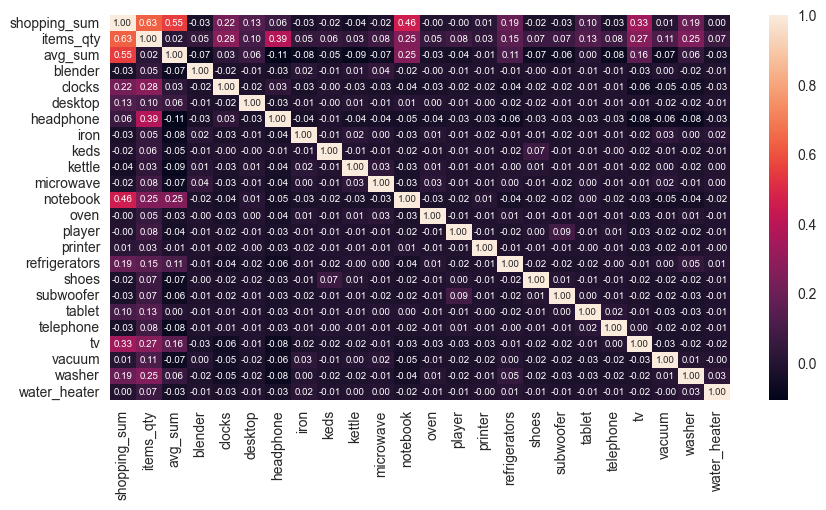

Корреляция по kendall


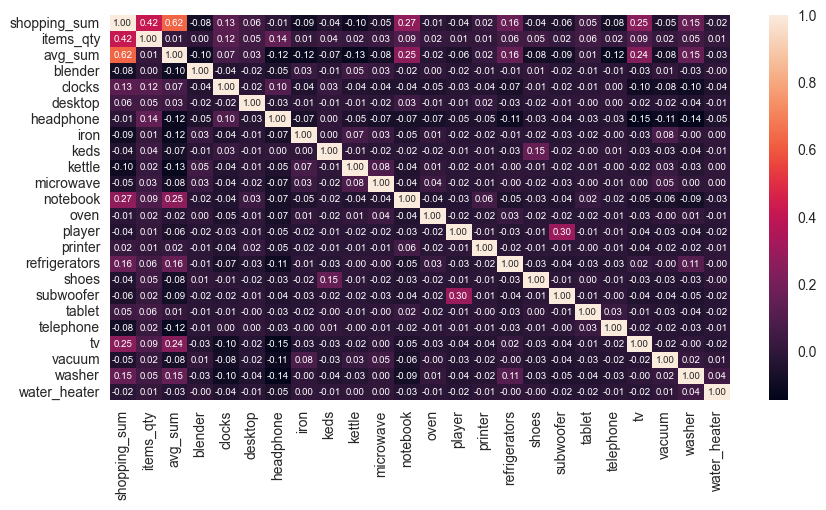

In [115]:
%matplotlib inline

for method in ['pearson', 'kendall']:
    cols = short_cols(df, 600)
    print(f'Корреляция по {method}')
    g = sns.heatmap(df[cols].corr(method=method), annot=True,fmt='.2f', annot_kws={"size":7})
    if g.get_yticklabels():
        g.set_yticklabels(labels=g.get_yticklabels(), rotation=0)
    if g.get_xticklabels():
        g.set_xticklabels(g.get_xticklabels(), rotation=90)
    cols = short_cols(df)
    plt.show()

In [116]:
data_for_segmentation = df[cols]
data_scaled = scaler.fit_transform(data_for_segmentation)

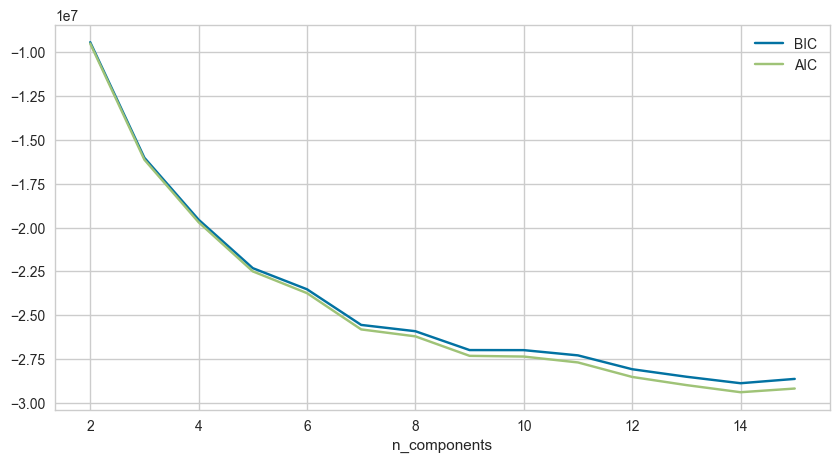

## <font color="BlueViolet">Поиск оптимального значения для числа сегментов

In [119]:
%%time
# 5m 37s
col_names = ['Segment','s_mean','s_std', 's_vc', 's_min','s_max', 'max_min_ratio']
results_sil_em = {} # Силуэт - не работает с нашим датасетом, молча виснет на metrics.silhouette_score
results_db_em = {}  # Дэвис Булдинг
results_kh_em = {}  # Калински-Харабаш
MAX_R=30

#df = df[df['user_id'].isin(rfm_df['user_id'])] # Убрали выбросы, обнаруженные в модели RFM
df.drop(df[df['avg_qty'] < 1.19].index, inplace=True) # Убираем покупателей единственной категории

#cols = short_cols(df)

scaler = StandardScaler()
data_for_segmentation = df[cols]
data_scaled = scaler.fit_transform(data_for_segmentation)

data = pd.DataFrame(columns=col_names)
for seg in tqdm(range(5, MAX_R)):
    gmm = GaussianMixture(n_components = seg, random_state = 42) #, max_iter = 100
    segs = gmm.fit_predict(data_scaled)
    
    x_score = metrics.silhouette_score(data_scaled, segs)
    results_sil_em.update({seg: x_score})

    x_score = metrics.davies_bouldin_score(data_scaled, segs)
    results_db_em.update({seg: x_score})

    x_score = metrics.calinski_harabasz_score(data_scaled, segs)
    results_kh_em.update({seg: x_score})
    
    tdf = pd.DataFrame(segs, columns=['Segs']).groupby('Segs').size()
    data = pd.concat([data, pd.DataFrame([[seg, tdf.mean(), tdf.std(), 
                                           tdf.std() * 100.0 / tdf.mean(), 
                                           tdf.min(), tdf.max(), tdf.max()/tdf.min()]], 
                                         columns = col_names)], axis=0, ignore_index = True)

  0%|          | 0/25 [00:00<?, ?it/s]

CPU times: total: 10min 26s
Wall time: 5min 39s


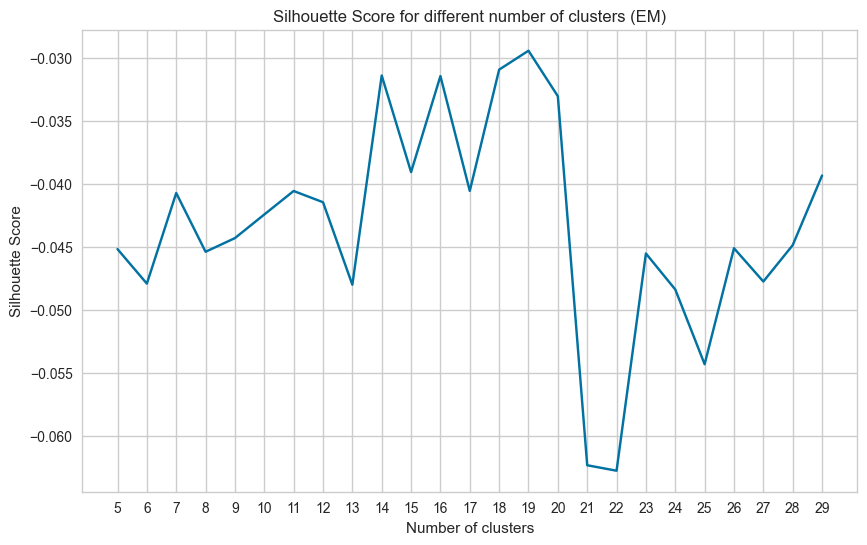

In [120]:
# Силуэт

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(10, 6))
plt.plot(list(results_sil_em.keys()), list(results_sil_em.values()), label = 'Silhouette Score')
plt.xticks(np.arange(5, MAX_R, step = 1))
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for different number of clusters (EM)')
plt.show();

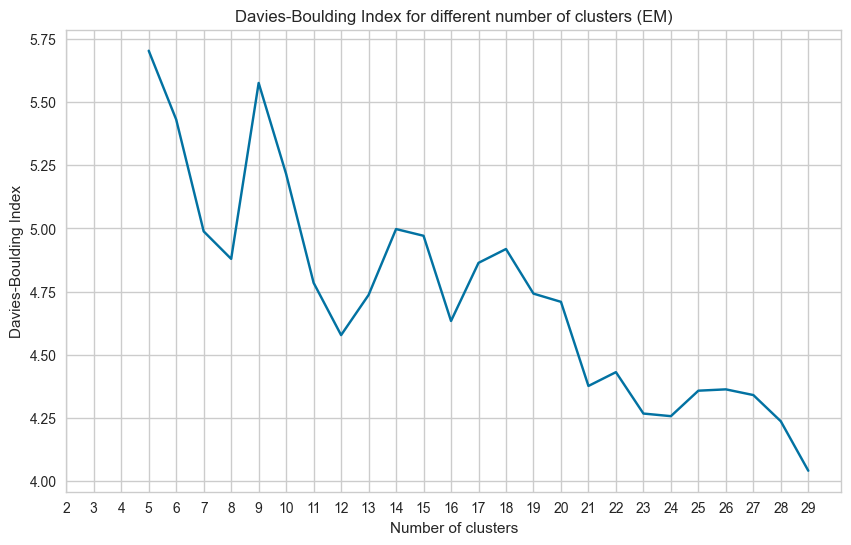

In [121]:
# Дэвис Булдинг

plt.figure(figsize=(10, 6))
plt.plot(list(results_db_em.keys()), list(results_db_em.values()), label = 'Davies-Boulding Index')
plt.xticks(np.arange(2, MAX_R, step = 1))
plt.xlabel('Number of clusters')
plt.ylabel('Davies-Boulding Index')
plt.title('Davies-Boulding Index for different number of clusters (EM)')
plt.show();

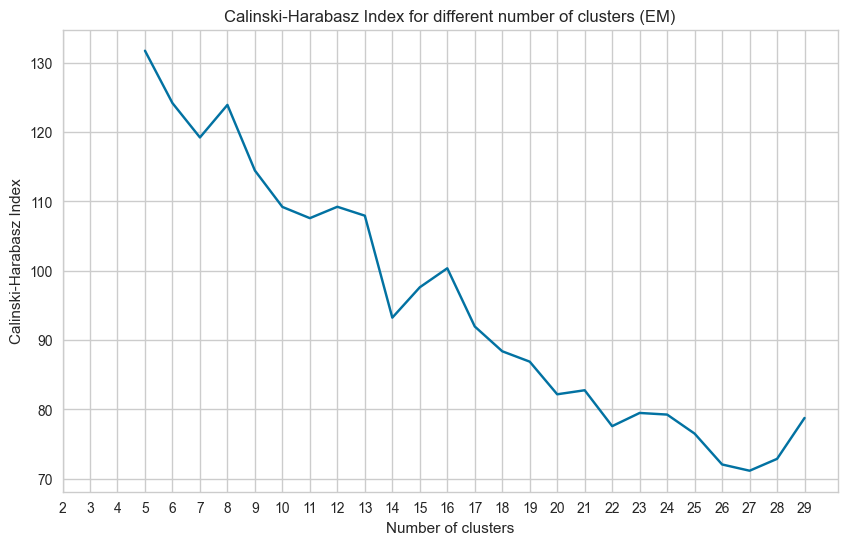

In [122]:
# Калински-Харабаш

plt.figure(figsize=(10, 6))
plt.plot(list(results_kh_em.keys()), list(results_kh_em.values()), label = 'Calinski-Harabasz Index')
plt.xticks(np.arange(2, MAX_R, step = 1))
plt.xlabel('Number of clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.title('Calinski-Harabasz Index for different number of clusters (EM)')
plt.show();

In [123]:
# Удаление мусорных кластеров с недостаточным числом записей

def clean_segment(df, min_percent=1):
    renumber = False # Требуется перенумерация сегментов
    total = df.shape[0]
    limit = total * min_percent // 100
    for seg in set(df['Segment']):
        if df[df['Segment']==seg].shape[0] < limit:
            renumber = True
            df = df.drop(df[df['Segment']==seg].index)
    if renumber:
        df['Segment'] = pd.factorize(df['Segment'])[0]
    return df

In [124]:
seg_file = Path(cache_dir + 'seg_2_40.pkl')
if not seg_file.is_file():
    data.to_pickle(seg_file)

In [125]:
data = pd.read_pickle(cache_dir + 'seg_2_40.pkl')
data

Segment   s_mean    s_std   s_vc s_min s_max  max_min_ratio
0        5 3,216.20 2,102.57  65.37   706  5844           8.28
1        6 2,680.17 1,929.90  72.01   455  5067          11.14
2        7 2,297.29 2,118.95  92.24   370  5401          14.60
3        8 2,010.12 1,965.69  97.79   454  6371          14.03
4        9 1,786.78 1,566.17  87.65   263  4832          18.37
5       10 1,608.10 1,535.11  95.46   138  4572          33.13
6       11 1,461.91 1,055.99  72.23   158  2943          18.63
7       12 1,340.08 1,047.02  78.13   159  2790          17.55
8       13 1,237.00   962.96  77.85   149  2910          19.53
9       14 1,148.64 1,440.78 125.43   102  5621          55.11
10      15 1,072.07 1,468.87 137.01   117  5579          47.68
11      16 1,005.06   955.49  95.07   118  2842          24.08
12      17   945.94 1,113.49 117.71    88  3680          41.82
13      18   893.39   926.89 103.75    47  3079          65.51
14      19   846.37   923.77 109.14    48  3095          64.48
15      20   804.05   907.12 112.82    45  3094          68.76
16      21   765.76 1,105.11 144.31    52  4704          90.46
17      22   730.95 1,027.44 140.56    54  4687          86.80
18      23   699.17 1,014.29 145.07    49  4725          96.43
19      24   670.04   982.25 146.60    46  4588          99.74
20      25   643.24   990.72 154.02    42  4706         112.05
21      26   618.50   968.72 156.62    43  4731         110.02
22      27   595.59   934.30 156.87    37  4708         127.24
23      28   574.32   921.84 160.51    38  4739         124.71
24      29   554.52   921.57 166.19     7  4712         673.14

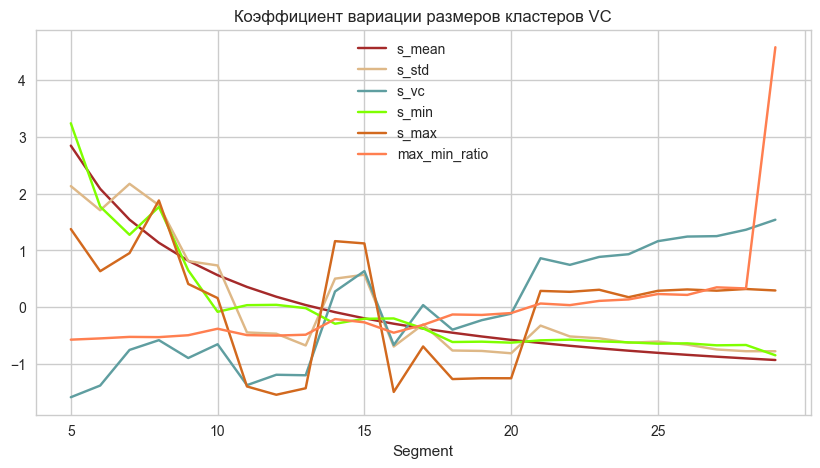

In [126]:
data2=data.set_index('Segment')
normalized_df=(data2-data2.mean())/data2.std()
normalized_df.plot(figsize=(10,5),color=custom_color, title='Коэффициент вариации размеров кластеров VC');

3 метода показали, что значение 14 будет подходящим. Метод силуэта предлагает значение 13. Пробуем несколько вариантов и принимаем значение 15, после чего отбрасываем слишком маленькие (мусорные) сегменты. Большее значение сильно раздробит датасет и в сегменте окажется недостаточно записей.

In [128]:
def plot_scatter(df, smode='pca'):
    data = df.copy()
    scols = short_cols(data)
    segs = df['Segment']
    if 'Seg2' in scols:
        scols.remove('Seg2')
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(data[scols])
    x_normal = normalize(x_scaled)
    x_normal = pd.DataFrame(x_normal)

    # reduce the dimensionality of the dataset
    if smode == 'pca':
        met = PCA(n_components=2)
    else:
        met = TruncatedSVD(n_components=2)
    x_principal = met.fit_transform(x_normal)
    x_principal = pd.DataFrame(x_principal)
    x_principal.columns = ['V1', 'V2']
    c_arr = [custom_color[x] for x in segs]
    plt.scatter(x=x_principal['V1'], y=x_principal['V2'], c=c_arr)

In [129]:
from mpl_toolkits import mplot3d

# Creating dataset
def plot_scatter3d(df, smode='pca'):
    data = df.copy()
    scols = short_cols(data)
    segs = df['Segment']
    if 'Seg2' in scols:
        scols.remove('Seg2')
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(data[scols])
    x_normal = normalize(x_scaled)
    x_normal = pd.DataFrame(x_normal)

    # reduce the dimensionality of the dataset
    if smode == 'pca':
        met = PCA(n_components=3)
    else:
        met = TruncatedSVD(n_components=2)
    x_principal = met.fit_transform(x_normal)
    x_principal = pd.DataFrame(x_principal)
    x_principal.columns = ['V1', 'V2','V3']
    c_arr = [custom_color[x] for x in segs]
    
    # Creating figure
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")

    # Creating plot
    ax.scatter3D(x_principal['V1'], x_principal['V2'], x_principal['V3'], color = c_arr)
    plt.title("PCA")

    # show plot
    plt.show()

In [130]:
def get_segmented_df(segments):
    sdf = read_showcase()
    cols = short_cols(df)
    data_for_segmentation = sdf[cols] # 'shopping_sum', 'avg_sum', 'shop_qty', 'accessories', 'apparel', 'appliances', 'auto', 'computers', 'construction', 'country_yard', 'electronics', 'furniture', 'kids', 'medicine', 'sport', 'stationery']] 
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data_for_segmentation)
    gmm = GaussianMixture(n_components = segments, random_state = 42, max_iter = 300)
    segs = gmm.fit_predict(data_scaled)
    sdf['Segment'] = segs
    return sdf

In [131]:
# DBSCAN

from sklearn.decomposition import PCA

data = df[cols].copy()
scaler = StandardScaler()
x_scaled = scaler.fit_transform(data)
from sklearn.preprocessing import normalize
x_normal = normalize(x_scaled)
x_normal = pd.DataFrame(x_normal)

# reduce the dimensionality of the dataset
pca = PCA(n_components=2)
x_principal = pca.fit_transform(x_normal)
x_principal = pd.DataFrame(x_principal)
x_principal.columns = ['V1', 'V2']
prdf(x_principal.head())

In [132]:
# При любых значениях min_samples и eps один кластер занимает 80+% всех записей, либо очень много записей отбрасываетс
dbscan = DBSCAN(eps=0.06, min_samples=100).fit(x_principal)
labels = dbscan.labels_
data['Segment'] = dbscan.labels_
prdf(data.tail())

10
0	10496	65.3%
1	204	1.3%
2	343	2.1%
3	112	0.7%
4	455	2.8%
5	607	3.8%
6	209	1.3%
7	119	0.7%
8	167	1.0%
9	94	0.6%
10	111	0.7%
-1	3164	19.7%


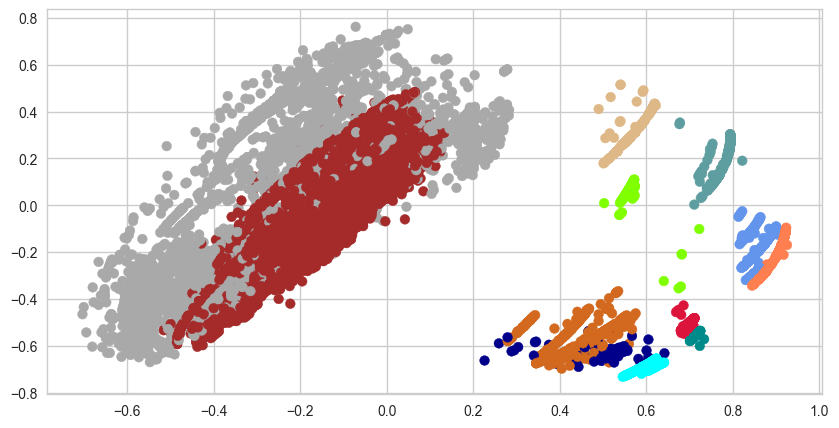

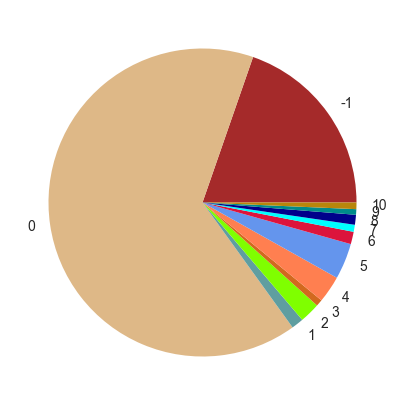

In [133]:
dbsegmax = max(dbscan.labels_)
#print(set(dbscan.labels_))
print(dbsegmax)
for a in set(data['Segment']):
    print(f"{a}\t{data[data['Segment']==a].shape[0]}\t{100*data[data['Segment']==a].shape[0]/data.shape[0]:.1f}%")
plot_scatter(data)
data['cluster'] = data['Segment']
show_pie(data)

In [134]:
df = read_showcase()
df.drop(df[df['avg_qty'] < 1.19].index, inplace=True) # Убираем покупателей единственной категории
df.set_index('user_id', inplace=True)
cols = short_cols(df)
print(f'Осталось категорий для анализа: {len(cols)}')

Осталось категорий для анализа: 64


In [135]:
%%time
#
segments = 16
random.seed(42)
#df = get_segmented_df(segments)

data_for_segmentation = df[cols] # 'shopping_sum', 'avg_sum', 'shop_qty', 'accessories', 'apparel', 'appliances', 'auto', 'computers', 'construction', 'country_yard', 'electronics', 'furniture', 'kids', 'medicine', 'sport', 'stationery']] 
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_for_segmentation)
gmm = GaussianMixture(n_components = segments, random_state = 42, max_iter = 100)
segs = gmm.fit_predict(data_scaled)
df['Segment'] = segs

CPU times: total: 20.3 s
Wall time: 11.6 s


Деление на сегменты


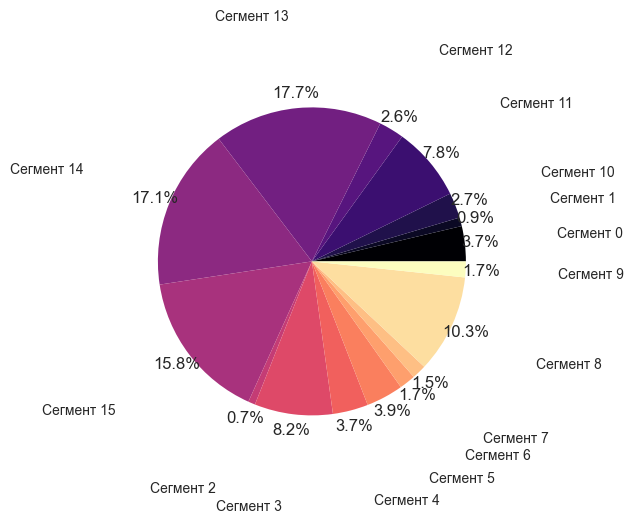

In [136]:
df['Seg2'] = 'Сегмент ' + df['Segment'].astype(str)
print('Деление на сегменты')
a=df.groupby('Seg2').size().plot(kind='pie', cmap='magma', autopct='%1.1f%%', labeldistance=1.6, pctdistance=1.1)

In [137]:
df = clean_segment(df, 1) # Удаляем сегменты, занимающие менее 1 % от общего числа записей в датасете
segments = df['Segment'].max()+1 # Получаем новое максимальное значение.

In [138]:
df.to_pickle(showcase_seg_file) # Сохраняем разбиение по сегментам для последующего использования

In [139]:
# gmm.means_

In [140]:
df['Seg2'] = 'Сегмент ' + df['Segment'].astype(str)

Деление на сегменты с удалением тех, чей размер < 1%


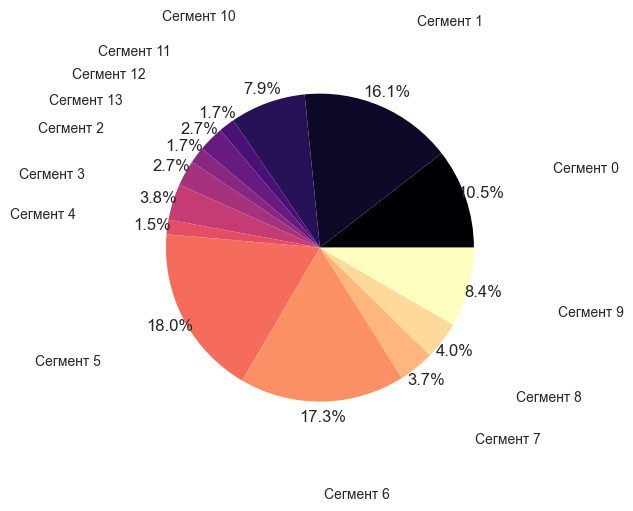

In [141]:
print('Деление на сегменты с удалением тех, чей размер < 1%')
a=df.groupby('Seg2').size().plot(kind='pie', cmap='magma', autopct='%1.1f%%', labeldistance=1.6, pctdistance=1.1);

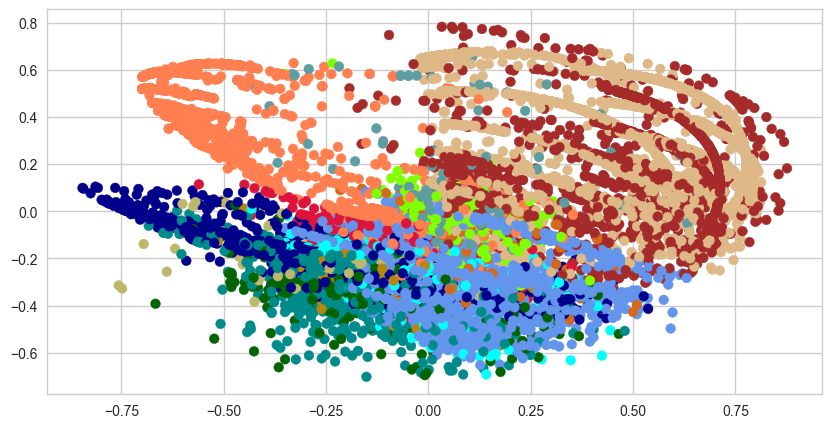

In [142]:
plot_scatter(df)

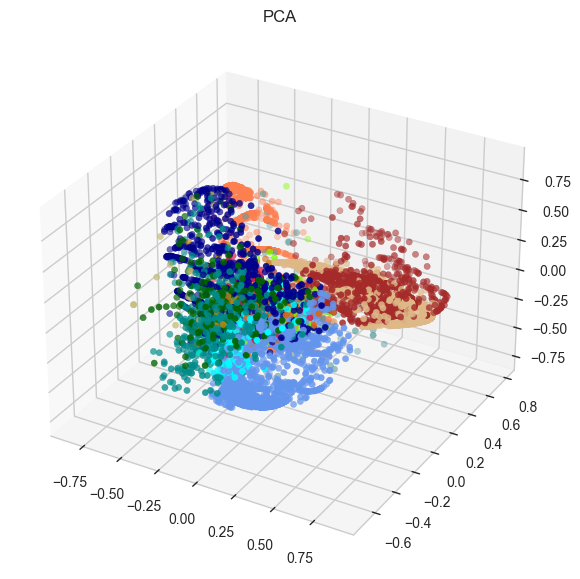

In [143]:
plot_scatter3d(df)

In [144]:
if 'Segment' not in cols:
    cols.append('Segment')
df[cols].head()

shopping_sum  items_qty  avg_sum  acoustic  air_conditioner  \
user_id                                                                  
512742880      1,319.93          2 1,319.93         0                0   
526631741        315.68          2   315.68         0                0   
547028884      2,000.71          5 1,000.36         0                0   
514805015      2,872.16          5 1,436.08         0                0   
542418394        857.03         10   122.43         0                0   

           air_heater  alarm  bag  bed  bicycle  ...  telephone  toster  toys  \
user_id                                          ...                            
512742880           0      0    0    0        0  ...          0       0     0   
526631741           0      0    0    0        0  ...          0       0     0   
547028884           0      0    0    0        0  ...          0       0     0   
514805015           0      0    0    0        0  ...          0       0     0   
542418394           0      0    0    0        0  ...          0       0     0   

           tv  vacuum  videocards  videoregister  washer  water_heater  \
user_id                                                                  
512742880   0       0           0              0       0             0   
526631741   0       0           0              0       0             0   
547028884   0       0           0              0       0             0   
514805015   0       0           0              0       0             0   
542418394   0       0           0              0       1             0   

           Segment  
user_id             
512742880        0  
526631741        1  
547028884        2  
514805015        0  
542418394        3  

[5 rows x 65 columns]

In [145]:
df.head()

shop_qty last_purchase  shopping_sum  items_qty  avg_qty  avg_sum  \
user_id                                                                        
512742880         1    2019-10-01      1,319.93          2     2.00 1,319.93   
526631741         1    2019-10-02        315.68          2     2.00   315.68   
547028884         2    2019-10-01      2,000.71          5     2.50 1,000.36   
514805015         2    2019-10-01      2,872.16          5     2.50 1,436.08   
542418394         7    2019-10-24        857.03         10     1.43   122.43   

           freq  acoustic  air_conditioner  air_heater  ...  winch  Monday  \
user_id                                                 ...                  
512742880    54         0                0           0  ...      0       0   
526631741     8         0                0           0  ...      0       0   
547028884    82         0                0           0  ...      0       0   
514805015    44         0                0           0  ...      0       0   
542418394   120         0                0           0  ...      0       1   

           Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday  Segment  \
user_id                                                                      
512742880        0          0         0       0         2       0        0   
526631741        0          0         0       0         0       2        1   
547028884        0          0         0       0         5       0        2   
514805015        0          0         0       0         5       0        0   
542418394        0          0         0       6         0       3        3   

                Seg2  
user_id               
512742880  Сегмент 0  
526631741  Сегмент 1  
547028884  Сегмент 2  
514805015  Сегмент 0  
542418394  Сегмент 3  

[5 rows x 140 columns]

In [146]:
save_cols = cols
cols = short_cols(df, 900) # Ограничиваем число категорий, чтобы график был более читаемым
categories = dataset[SPLIT_CATEGORY].unique().sort_values(ascending=True).tolist()
mycols = categories
#mycols.append('Segment')
for cat in categories:
    if cat not in cols:
        mycols.remove(cat)
mycols_s = ['Segment'] + mycols
cols = save_cols
del save_cols

In [147]:
seg_df = df[mycols_s].groupby(by=['Segment'], as_index=False)[mycols].sum()

In [148]:
# Cтандартное отклонение
#seg_df-np.std(seg_df[mycols])

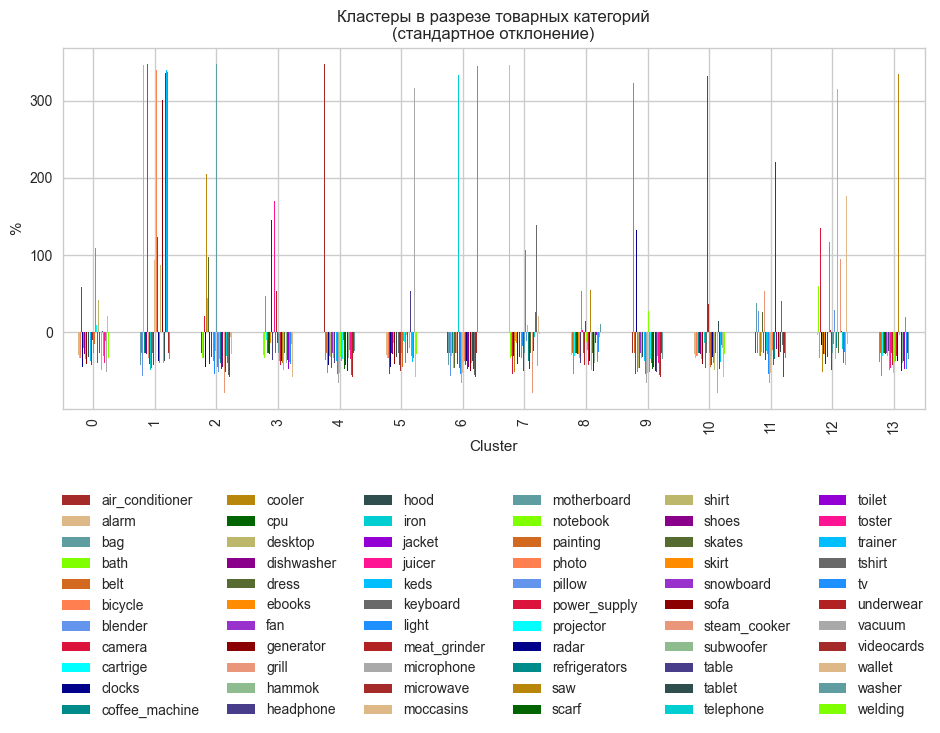

In [149]:
x = seg_df[mycols]
dev = (100*(x-x.mean())/x.std())[mycols]
ax = dev.plot(y=mycols, kind="bar",figsize=(10,8),color=custom_color, 
                                        xlabel='Cluster', ylabel='%', grid=True,
                                        title='Кластеры в разрезе товарных категорий\n(стандартное отклонение)').legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),  ncol=6);
plt.tight_layout()

In [150]:
print('Доминирующие категории в сегментах')
for seg in range(segments):
    print(seg, dev[dev.index==seg][mycols].stack(dropna=True).nlargest(7).reset_index()['level_1'].values)

Доминирующие категории в сегментах
0 ['notebook' 'desktop' 'juicer' 'subwoofer' 'pillow' 'camera' 'shirt']
1 ['fan' 'cartrige' 'welding' 'ebooks' 'projector' 'trainer' 'photo']
2 ['videocards' 'motherboard' 'cpu' 'keyboard' 'power_supply' 'cooler'
 'dress']
3 ['hood' 'grill' 'toster' 'steam_cooker' 'juicer' 'generator' 'sofa']
4 ['air_conditioner' 'dishwasher' 'hood' 'bicycle' 'refrigerators' 'saw'
 'generator']
5 ['belt' 'headphone' 'shoes' 'vacuum' 'blender' 'moccasins' 'underwear']
6 ['washer' 'refrigerators' 'microwave' 'iron' 'vacuum' 'tv'
 'air_conditioner']
7 ['alarm' 'subwoofer' 'tshirt' 'radar' 'painting' 'microphone' 'toster']
8 ['saw' 'iron' 'bicycle' 'microwave' 'washer' 'juicer' 'shoes']
9 ['skates' 'tablet' 'bag' 'radar' 'clocks' 'headphone' 'notebook']
10 ['telephone' 'meat_grinder' 'keds' 'blender' 'microwave' 'tablet'
 'refrigerators']
11 ['coffee_machine' 'scarf' 'steam_cooker' 'grill' 'toster' 'bag' 'blender']
12 ['shirt' 'tshirt' 'moccasins' 'scarf' 'light' 'wallet'

## В обучении ассоциативным правилам выделяют три типа алгоритмов.
- Apriori.
- Eclat.
- FP Growth.

### Введение в APRIORI
В основе Apriori  —  поиск частотных множеств элементов в наборе данных. Этот алгоритм построен на ассоциациях и корреляциях между наборами элементов. Он применяется на рекомендательных платформах  —  там, где мы обычно видим «вам также может понравиться».

## <font color="DarkViolet"> Apriori Algorithm
- библиотека mlxtend

In [153]:
MIN_SUPPORT = 0.04 # С параметром 1% время работы ноутбука заняло более 1 часа. ECLAT метод очень долго обрабатывает данные.
SET_SIZE=3

In [154]:
def defrost(df):
    for col in ['antecedents', 'consequents']:
        df[col] = df[col].astype('string')
        df[col] = df[col].str.removeprefix("frozenset({")
        df[col] = df[col].str.removesuffix("})") 
    return df

In [155]:
%%time
AP_TOP = 5 # Скольсо строк таблицы показывать
METHOD='Apriori'
encoder = TransactionEncoder()
key_index = 'user_id'
purchase_backup = purchase.copy() # На всякий случай сохраним исходный вариант purchase

# Удаляем покупателей, с покупками из единственной категории
pdata = purchase.groupby('user_id')[SPLIT_CATEGORY].nunique()
purchase.drop(purchase[purchase['user_id'].isin(pdata[pdata==1].index.tolist())].index, inplace=True)
# Далее ничего не меняем в purchase и пользуемся для выборки

apriori_rules = []
apriori_pair = pd.DataFrame()

for segment in np.arange(segments):
    data = purchase[purchase['user_id'].isin(df.index[df['Segment']==segment].tolist())][[key_index, SPLIT_CATEGORY]]
    transactions = data.groupby(key_index)[SPLIT_CATEGORY].apply(list).tolist()
    transactions_encoded = encoder.fit(transactions).transform(transactions)
    df_encoded = pd.DataFrame(transactions_encoded, columns=encoder.columns_)

    # Меняя параметр min_support (%) мы получим более широкую или узкую выборку
    frequent_itemsets = apriori(df_encoded, min_support=MIN_SUPPORT, use_colnames=True)
    frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda itemset: len(itemset))
    rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.001)
    apriori_rules.append(rules)
    print(f'{METHOD}, Сегмент: {segment}')
    #add_df = frequent_itemsets[frequent_itemsets['length'] >= SET_SIZE].sort_values('support',ascending=False)
    rules2 = rules.copy()
    rules2['segment'] = segment
    rules2["antecedents_length"] = rules2["antecedents"].apply(lambda x: len(x))
    rules2["consequents_length"] = rules2["consequents"].apply(lambda x: len(x))
    apriori_pair = pd.concat([apriori_pair, rules2], ignore_index = True)
    prdf(frequent_itemsets[frequent_itemsets['length'] >= SET_SIZE].sort_values('support',ascending=False).head())
    print(f'{METHOD}, Сегмент: {segment}')
    prdf(apriori_rules[segment].sort_values('support',ascending=False).head(AP_TOP))

apriori_pair = defrost(apriori_pair)
apriori_pair.to_excel('apriori_pairs.xlsx')
del apriori_pair

Apriori, Сегмент: 0


Apriori, Сегмент: 0


Apriori, Сегмент: 1


Apriori, Сегмент: 1


Apriori, Сегмент: 2


Apriori, Сегмент: 2


Apriori, Сегмент: 3


Apriori, Сегмент: 3


Apriori, Сегмент: 4


Apriori, Сегмент: 4


Apriori, Сегмент: 5


Apriori, Сегмент: 5


Apriori, Сегмент: 6


Apriori, Сегмент: 6


Apriori, Сегмент: 7


Apriori, Сегмент: 7


Apriori, Сегмент: 8


Apriori, Сегмент: 8


Apriori, Сегмент: 9


Apriori, Сегмент: 9


Apriori, Сегмент: 10


Apriori, Сегмент: 10


Apriori, Сегмент: 11


Apriori, Сегмент: 11


Apriori, Сегмент: 12


Apriori, Сегмент: 12


Apriori, Сегмент: 13


Apriori, Сегмент: 13


CPU times: total: 1.53 s
Wall time: 1.69 s


## <font color="DarkViolet">Implementation of ECLAT using Python

ECLAT (Equivalence Class Clustering and bottom-up Lattice Traversal)

Кластеризация классов эквивалентности и обход решетки снизу вверх.

ECLAT, Сегмент: 0


ECLAT, Сегмент: 0


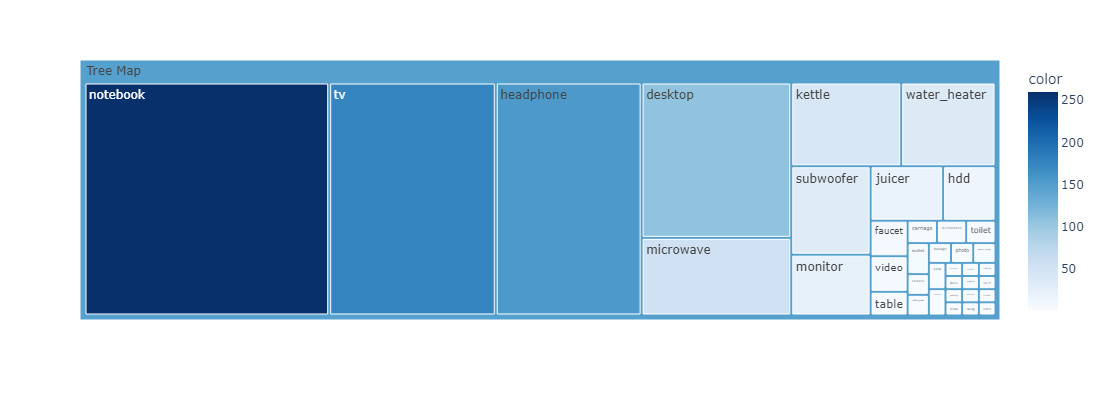

ECLAT, Сегмент: 1


ECLAT, Сегмент: 1


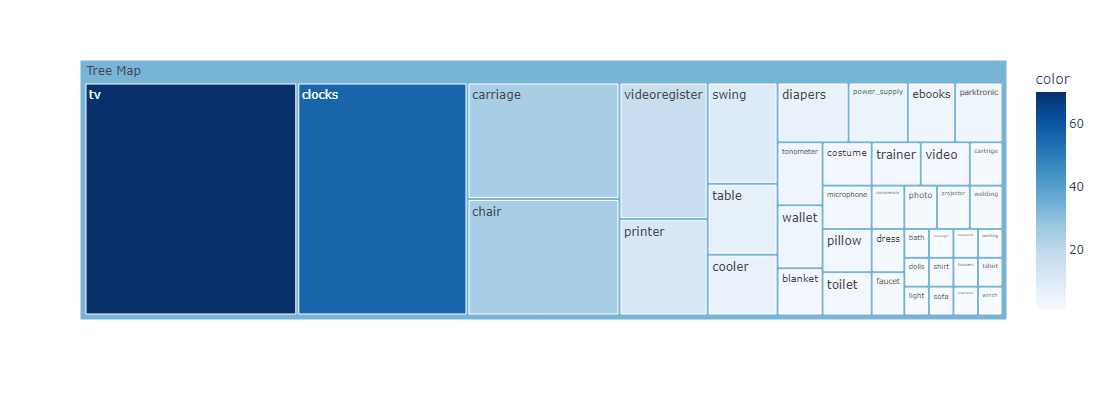

ECLAT, Сегмент: 2


ECLAT, Сегмент: 2


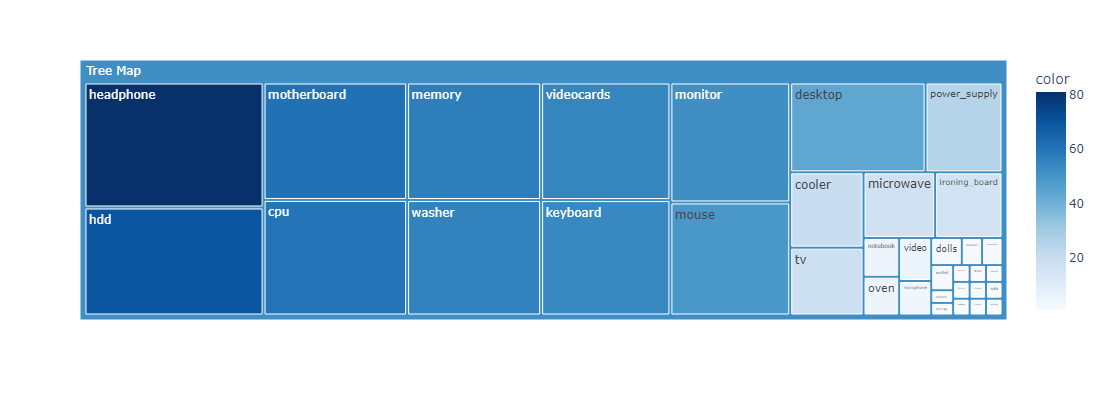

ECLAT, Сегмент: 3


ECLAT, Сегмент: 3


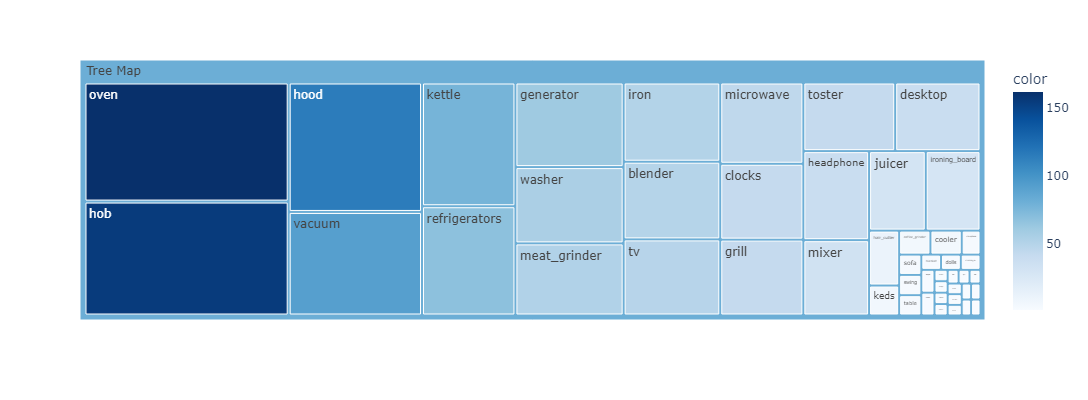

ECLAT, Сегмент: 4


ECLAT, Сегмент: 4


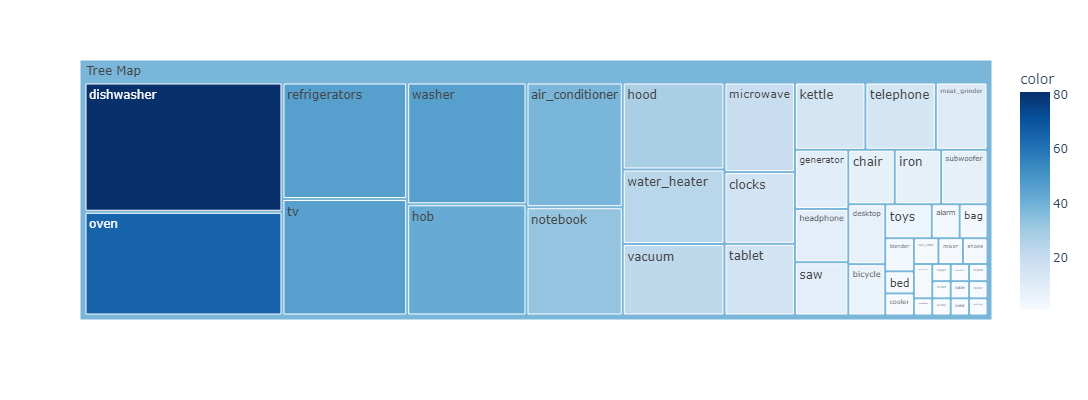

ECLAT, Сегмент: 5


ECLAT, Сегмент: 5


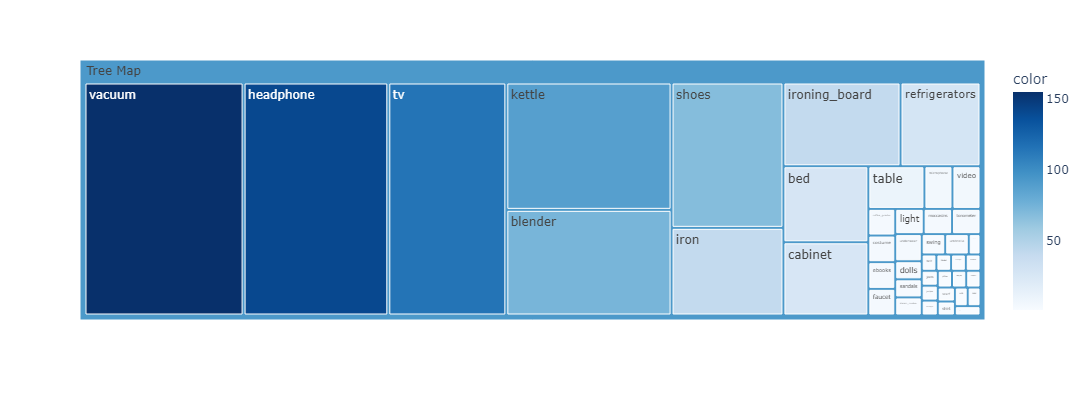

ECLAT, Сегмент: 6


ECLAT, Сегмент: 6


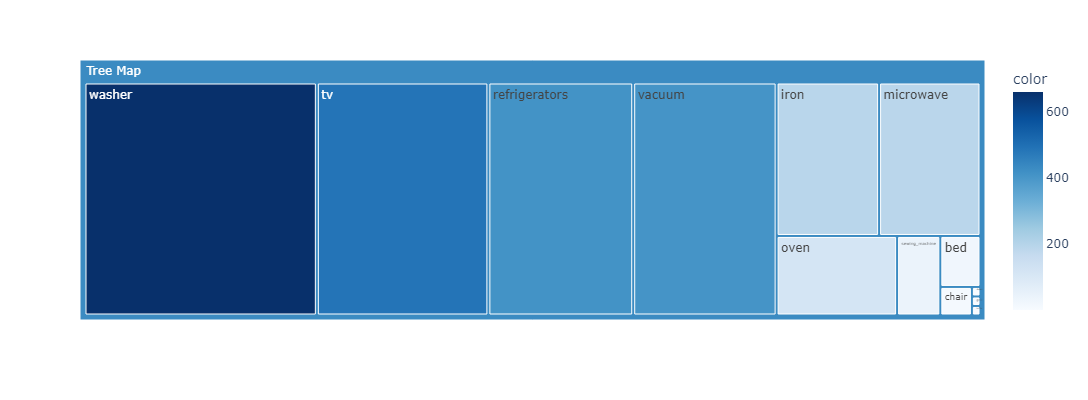

ECLAT, Сегмент: 7


ECLAT, Сегмент: 7


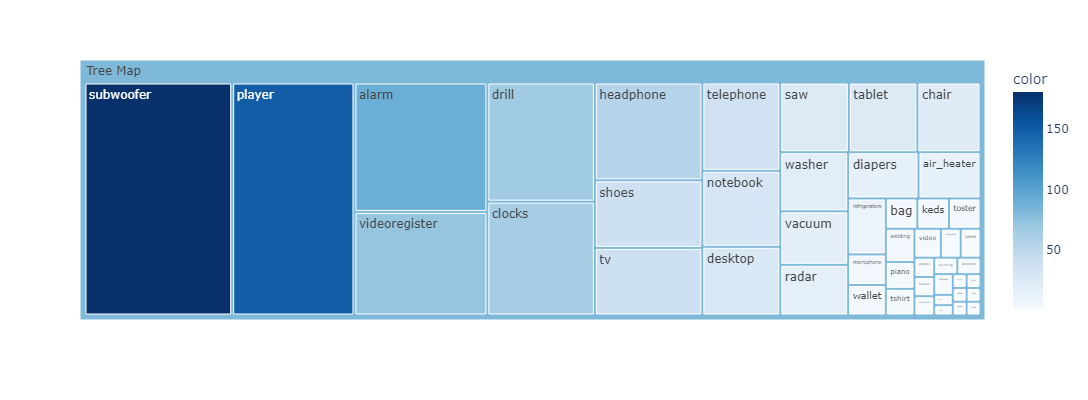

ECLAT, Сегмент: 8


ECLAT, Сегмент: 8


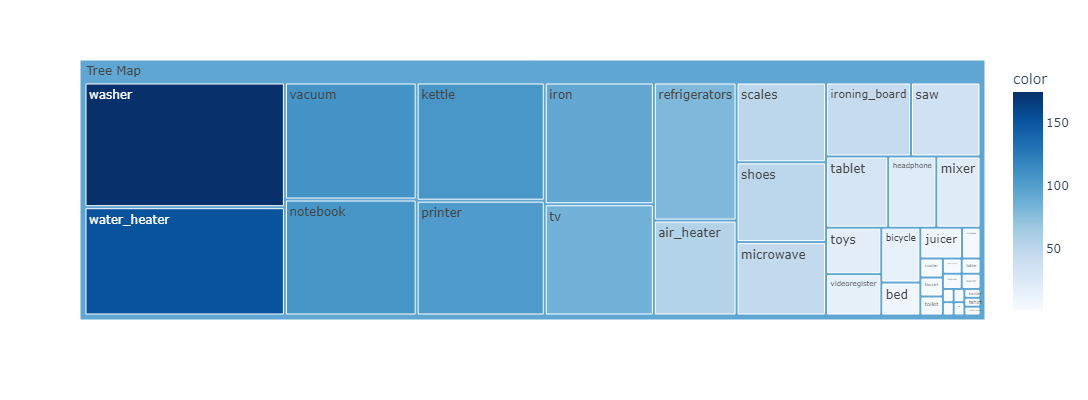

ECLAT, Сегмент: 9


ECLAT, Сегмент: 9


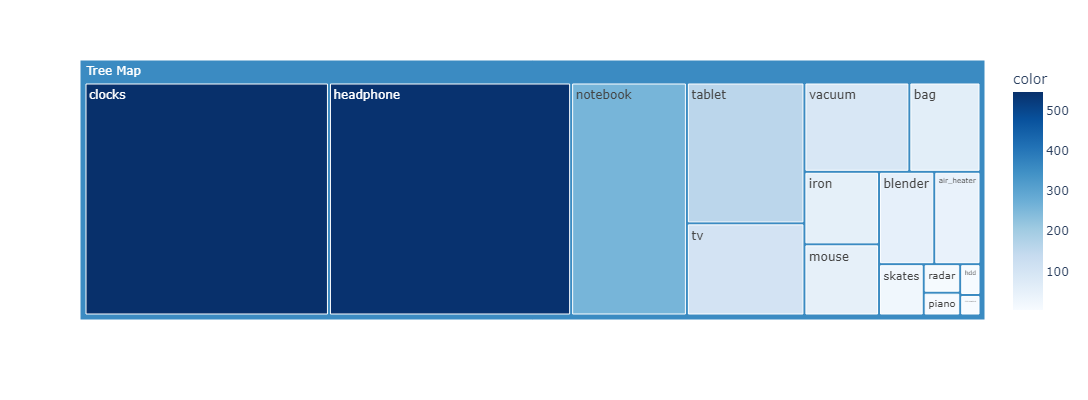

ECLAT, Сегмент: 10


ECLAT, Сегмент: 10


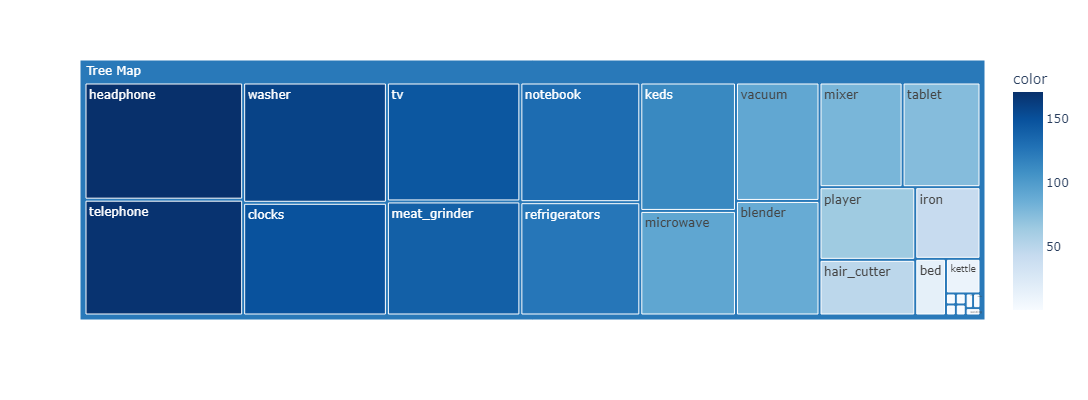

ECLAT, Сегмент: 11


ECLAT, Сегмент: 11


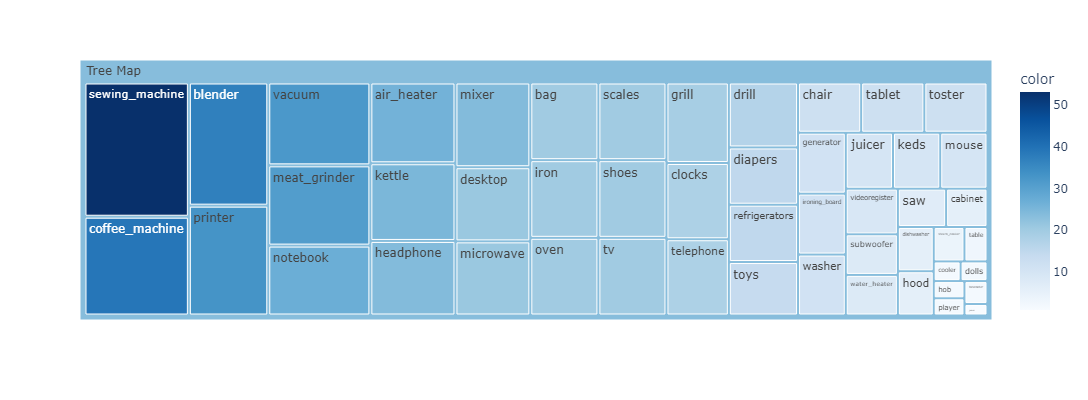

ECLAT, Сегмент: 12


ECLAT, Сегмент: 12


ECLAT, Сегмент: 13


ECLAT, Сегмент: 13


In [157]:
METHOD='ECLAT'
for segment in range(segments):
    data = purchase[purchase['user_id'].isin(df.index[df['Segment']==segment].tolist())][[key_index, SPLIT_CATEGORY]]
    transactions = data.groupby(key_index)[SPLIT_CATEGORY].apply(list).tolist()
    transactions_encoded = encoder.fit(transactions).transform(transactions)
    data = pd.DataFrame(data=transactions)
    eclat = ECLAT(data=data)
    items_total = eclat.df_bin.astype(int).sum(axis=0)
    items_support = [eclat.support()[x] for x in items_total.index]
    # count items in each row
    items_per_transaction = eclat.df_bin.astype(int).sum(axis=1)
    # Frequent category list
    # Loading items per column stats to the DataFrame
    xdf = pd.DataFrame({'items': items_total.index, 'support': items_support, 'transactions': items_total.values}) 
    # cloning pandas DataFrame for visualization purpose  
    df_table = xdf.sort_values("transactions", ascending=False)
    #  Top 5 most popular products/items
    print(f'{METHOD}, Сегмент: {segment}')
    prdf(df_table.head(5).style.background_gradient(cmap='Blues'))
    print(f'{METHOD}, Сегмент: {segment}')
    # Frequent item list - Tree Map
    # importing required module
    # to have a same origin
    df_table["all"] = "Tree Map"
    #dftmp = df_table.applymap(lambda x: x if x else "null")  # There are better approaches, only for clarity of preprocess

    # to have a same origin
    # creating tree map using plotly
    df_table.drop(df_table[df_table['transactions']==0].index, inplace=True)
    fig = px.treemap(df_table.head(50), path=['all', "items"], values='transactions',
                      color=df_table["transactions"].head(50), hover_data=['items'],
                      color_continuous_scale='Blues',
                      width = 800, height = 400
                    )
    # ploting the treemap
    fig.show();
        

## Generating association rules
### To generate association rules, we need to define:

- Minimum support – should be provided as a percentage of the overall items from the dataset
- Minumum combinations – the minimum amount of items in the transaction
- Maximum combinations – the minimum amount of items in the transaction

Note: the higher the value of the maximum combinations the longer the calculation will take.

In [159]:
%%time
# 50min 42s
#min_support = MIN_SUPPORT
# start from transactions containing at least 2 items
min_combination = 3
# up to maximum items per transaction
eclat_pair = []
for segment in tqdm(range(segments)):
    data = purchase[purchase['user_id'].isin(df.index[df['Segment']==segment].tolist())][[key_index, SPLIT_CATEGORY]]
    transactions = data.groupby(key_index)[SPLIT_CATEGORY].apply(list).tolist()
    transactions_encoded = encoder.fit(transactions).transform(transactions)
    data = pd.DataFrame(data=transactions)
    eclat = ECLAT(data=data)
    items_total = eclat.df_bin.astype(int).sum(axis=0)
    # count items in each row
    items_per_transaction = eclat.df_bin.astype(int).sum(axis=1)
    # Frequent category list
    # Loading category per column stats to the DataFrame
    xdf = pd.DataFrame({'items': items_total.index, 'transactions': items_total.values}) 
    max_combination = max(items_per_transaction)
    rule_indices, rule_supports = eclat.fit(min_support=MIN_SUPPORT,
                                                 min_combination=SET_SIZE, #min_combination,
                                                 max_combination=3, #max_combination,
                                                 separator=' & ',
                                                 verbose=False)
    # Association rules DataFrame
    result = pd.DataFrame(rule_supports.items(),columns=['Item', 'Support'])
    result = result[['Support', 'Item']]
    print(f'\n{METHOD}, Сегмент: {segment}')
    prdf(result.sort_values(by=['Support'], ascending=False).head(5))
    eclat_pair.append(rule_supports)

eclat_df = pd.DataFrame()
for seg, eclat_data in enumerate(eclat_pair):
    tmp = pd.DataFrame(eclat_data.items())
    tmp['segment'] = seg
    eclat_df = pd.concat([eclat_df, tmp], ignore_index = True)
eclat_df.rename(columns = {0: 'categoryset', 1: 'support'}, inplace=True)
eclat_df.to_excel('eclat_pairs.xlsx')
#del eclat_df

  0%|          | 0/14 [00:00<?, ?it/s]


ECLAT, Сегмент: 0



ECLAT, Сегмент: 1



ECLAT, Сегмент: 2



ECLAT, Сегмент: 3



ECLAT, Сегмент: 4



ECLAT, Сегмент: 5



ECLAT, Сегмент: 6



ECLAT, Сегмент: 7



ECLAT, Сегмент: 8



ECLAT, Сегмент: 9



ECLAT, Сегмент: 10



ECLAT, Сегмент: 11



ECLAT, Сегмент: 12



ECLAT, Сегмент: 13


CPU times: total: 2min 15s
Wall time: 2min 15s


## <font color="DarkViolet">FP-growth Algorithm
- библиотека mlxtend

In [161]:
%%time
fp_pair = []
fpg_pair = pd.DataFrame()
METHOD='FP-Growth'
for segment in np.arange(segments):
    data = purchase[purchase['user_id'].isin(df.index[df['Segment']==segment].tolist())][[key_index, SPLIT_CATEGORY]]
    transactions = data.groupby(key_index)[SPLIT_CATEGORY].apply(list).tolist()
    transactions_encoded = encoder.fit(transactions).transform(transactions)
    df_encoded = pd.DataFrame(transactions_encoded, columns=encoder.columns_)
    
    # Алгоритм FP growth
    res = fpgrowth(df_encoded,min_support=MIN_SUPPORT, use_colnames=True)
    
    # Теперь мы можем создавать различные правила ассоциаций из часто встречающихся элементов.
    rules = association_rules(res, metric="lift", min_threshold=1)
    fp_pair.append(rules)
    # prdf(res)
    # Мы можем получить разные правила ассоциации в зависимости от величины support, confidence и lift.
    # Мы также можем упорядочить элементы, чтобы узнать, какие элементы более связаны между собой.
    print(f'{METHOD}, Сегмент: {segment}')
    frequent_itemsets = res.copy()
    frequent_itemsets['length'] = res['itemsets'].apply(lambda itemset: len(itemset))
    prdf(frequent_itemsets[frequent_itemsets['length'] >= SET_SIZE].sort_values('support',ascending=False).head())
    
    print(f'{METHOD}, Сегмент: {segment}')
    rules['segment'] = segment
    fpg_pair = pd.concat([fpg_pair, rules], ignore_index = True)
    prdf(rules.sort_values("confidence",ascending=False).head(5))
fpg_pair = defrost(fpg_pair)
fpg_pair.to_excel('fpg_pairs.xlsx')
del fpg_pair

FP-Growth, Сегмент: 0


FP-Growth, Сегмент: 0


FP-Growth, Сегмент: 1


FP-Growth, Сегмент: 1


FP-Growth, Сегмент: 2


FP-Growth, Сегмент: 2


FP-Growth, Сегмент: 3


FP-Growth, Сегмент: 3


FP-Growth, Сегмент: 4


FP-Growth, Сегмент: 4


FP-Growth, Сегмент: 5


FP-Growth, Сегмент: 5


FP-Growth, Сегмент: 6


FP-Growth, Сегмент: 6


FP-Growth, Сегмент: 7


FP-Growth, Сегмент: 7


FP-Growth, Сегмент: 8


FP-Growth, Сегмент: 8


FP-Growth, Сегмент: 9


FP-Growth, Сегмент: 9


FP-Growth, Сегмент: 10


FP-Growth, Сегмент: 10


FP-Growth, Сегмент: 11


FP-Growth, Сегмент: 11


FP-Growth, Сегмент: 12


FP-Growth, Сегмент: 12


FP-Growth, Сегмент: 13


FP-Growth, Сегмент: 13


CPU times: total: 953 ms
Wall time: 981 ms


## <font color='DarkViolet'>Naive / Brute-Force Alghoritm

In [163]:
# Названия всех категорий 1 уровня
#dataset['category_code_level1'].unique().sort_values().tolist()

In [164]:
#pip install ipywidgets==7.7.5.

In [165]:
cat1='tv'
combo_set = []
for segment in tqdm(np.sort(df['Segment'].unique())):
    setOfItems = []
    #print(f'Segment={segment}')
    for user_id, row in df[df['Segment']==segment].iterrows():
        if row['avg_qty'] >= 1.0:
            tmpdata = purchase[purchase['user_id']==user_id]
            for session in tmpdata['user_session'].unique():
                if len(tmpdata[tmpdata['user_session']==session][SPLIT_CATEGORY].unique()) > 1:
                    setOfItems.append(' '.join(tmpdata[tmpdata['user_session']==session][SPLIT_CATEGORY].unique().sort_values(ascending=True).tolist()))    
    combo_set.append(setOfItems)

  0%|          | 0/14 [00:00<?, ?it/s]

In [166]:
print(f'Рекомендация для категории {cat1}:')
for cluster in range(len(combo_set)):
    pr_cluster = False
    for pair in Counter(combo_set[cluster]).most_common()[:7]:
        if cat1 in pair[0]:
            if not pr_cluster: # Print segment number only once
                print(f'Segment #{cluster}')
                pr_cluster = True
            tmp = pair[0].split()
            if tmp[0]==cat1:
                print(f'{tmp[1]} ({pair[1]})')
            else:
                print(f'{tmp[0]} ({pair[1]})')
    print()

Рекомендация для категории tv:
Segment #0
notebook (57)
desktop (12)
headphone (10)

Segment #1
clocks (16)
videoregister (3)



Segment #4
air_conditioner (20)
dishwasher (6)

Segment #5
vacuum (29)
headphone (21)

Segment #6
washer (133)
refrigerators (75)
microwave (34)

Segment #7
drill (7)

Segment #8
washer (10)

Segment #9
tablet (17)


Segment #11
grill (2)

Segment #12
acoustic (10)




In [167]:
# Витрина без деления на кластеры
dfv = pd.read_pickle(showcase_file)
dfv

user_id  shop_qty last_purchase  shopping_sum  items_qty  avg_qty  \
0       512742880         1    2019-10-01      1,319.93          2     2.00   
1       526631741         1    2019-10-02        315.68          2     2.00   
2       554754045         1    2019-10-22        120.96          1     1.00   
3       547028884         2    2019-10-01      2,000.71          5     2.50   
4       531646433         1    2019-10-02        133.81          1     1.00   
...           ...       ...           ...           ...        ...      ...   
155493  570342984         1    2019-11-11        463.07          1     1.00   
155494  517762593         1    2019-11-11        319.16          2     2.00   
155495  569205309         1    2019-11-11        173.26          1     1.00   
155496  554836187         1    2019-11-11        451.15          1     1.00   
155497  543444163         1    2019-11-11        101.26          1     1.00   

        avg_sum  freq  acoustic  air_conditioner  ...  water_heater  welding  \
0      1,319.93    54         0                0  ...             0        0   
1        315.68     8         0                0  ...             0        0   
2        120.96    49         0                0  ...             0        0   
3      1,000.36    82         0                0  ...             0        0   
4        133.81    48         0                0  ...             1        0   
...         ...   ...       ...              ...  ...           ...      ...   
155493   463.07     6         0                0  ...             0        0   
155494   319.16     8         0                0  ...             0        0   
155495   173.26     6         0                0  ...             0        0   
155496   451.15     4         0                0  ...             0        0   
155497   101.26     5         0                0  ...             0        0   

        winch  Monday  Tuesday  Wednesday  Thursday  Friday  Saturday  Sunday  
0           0       0        0          0         0       0         2       0  
1           0       0        0          0         0       0         0       2  
2           0       0        0          0         0       0         1       0  
3           0       0        0          0         0       0         5       0  
4           0       0        0          0         0       0         0       1  
...       ...     ...      ...        ...       ...     ...       ...     ...  
155493      0       0        1          0         0       0         0       0  
155494      0       0        2          0         0       0         0       0  
155495      0       0        1          0         0       0         0       0  
155496      0       0        1          0         0       0         0       0  
155497      0       0        1          0         0       0         0       0  

[155498 rows x 139 columns]

In [168]:
dataset_stats(dfv)

In [169]:
rfm_df

user_id  recency  frequency  monetary
0       253299396        5          4    246.85
1       303160429       29          3    340.59
2       310402868        0          9     77.22
3       340041246       28         28    339.70
4       378784732        1          7    122.78
...           ...      ...        ...       ...
155493  570326373        0          9     63.06
155494  570336925        0          4     21.88
155495  570339849        0         11    823.66
155496  570342853        0          9  1,079.56
155497  570342984        0          6    463.07

[155498 rows x 4 columns]

In [170]:
seconds = int(time.time() - start_time)
print("%d:%02d" % (seconds // 60, seconds - 60 * (seconds // 60),))

43:11


In [171]:
dataset

event_time event_type  product_id  \
5         2019-10-01 00:00:05 UTC       view     1480613   
22        2019-10-01 00:00:22 UTC       view     1480714   
45        2019-10-01 00:00:35 UTC       view     3601505   
47        2019-10-01 00:00:36 UTC       view     3600575   
50        2019-10-01 00:00:37 UTC       view     1701111   
...                           ...        ...         ...   
61743468  2019-11-11 23:58:11 UTC   purchase     4804055   
61743530  2019-11-11 23:58:36 UTC   purchase     1801805   
61743644  2019-11-11 23:59:22 UTC       view     3700756   
61743686  2019-11-11 23:59:39 UTC       view     3200549   
61743691  2019-11-11 23:59:41 UTC   purchase     2402422   

                            category_code             brand  price    user_id  \
5                       computers.desktop            pulser 908.62  512742880   
22                      computers.desktop            pulser 921.49  512742880   
45              appliances.kitchen.washer           samsung 463.15  526631741   
47              appliances.kitchen.washer  hotpoint-ariston 275.37  554754045   
50          computers.peripherals.monitor              acer 514.79  547028884   
...                                   ...               ...    ...        ...   
61743468      electronics.audio.headphone             apple 188.86  560615667   
61743530             electronics.video.tv             artel 242.40  513733245   
61743644    appliances.environment.vacuum           samsung 110.66  559490541   
61743686  appliances.kitchen.meat_grinder          dauscher  30.86  549631061   
61743691          appliances.kitchen.hood             hansa 101.26  543444163   

                                  user_session    category_code_level1  \
5         0d0d91c2-c9c2-4e81-90a5-86594dec0db9               computers   
22        0d0d91c2-c9c2-4e81-90a5-86594dec0db9               computers   
45        5ec9bd77-beef-443e-b987-62ffb55b8132      appliances.kitchen   
47        bd0302ef-c5ca-4b6a-b916-95cc2840c72c      appliances.kitchen   
50        3ea7c620-a8d7-45c5-9ced-2e9874e2f549   computers.peripherals   
...                                        ...                     ...   
61743468  e468d79f-ba7b-4055-9b35-28b987a40ca4       electronics.audio   
61743530  c3bd6731-46f6-4ffe-b725-003a3838890c       electronics.video   
61743644  969f9219-45ed-4527-be34-2721f1cd95dc  appliances.environment   
61743686  1900a4d2-51ff-4ca1-aab5-0c38528ab8ac      appliances.kitchen   
61743691  bf7abe27-5faa-417b-8eb2-4fc8b6d9f6f9      appliances.kitchen   

         category_code_level2      dow  
5                     desktop  Tuesday  
22                    desktop  Tuesday  
45                     washer  Tuesday  
47                     washer  Tuesday  
50                    monitor  Tuesday  
...                       ...      ...  
61743468            headphone   Monday  
61743530                   tv   Monday  
61743644               vacuum   Monday  
61743686         meat_grinder   Monday  
61743691                 hood   Monday  

[4245389 rows x 11 columns]